# Quality Assessment for ERA5 Drought Indicator: Reproducibility

Production date: 2026-xx-xx

**Please note that this repository is used for development and review, so quality assessments should be considered work in progress until they are merged into the main branch.**

Dataset version: 1.0.

Produced by: Enis Gerxhalija, Olivier Burggraaff (National Physical Laboratory).

## 🌍 Use case: Retrieving drought indicators from the ERA5-Drought dataset 

## ❓ Quality assessment question
* **Are the drought indicators in the ERA5-Drought dataset consistent with and reproducible from ERA5 data?**
* **Are the drought indicators in the ERA5-Drought dataset presented in a format that ensures optimal usability for users?**

**Feedback:** Make reference format consistent with Atlas and AgERA5 notebooks
(further feedback on introduction at later stage)

Human-induced climate change is likely the primary driver behind the number of increased droughts and heavy precipitation since the 1950s, per the latest assessment report by the Intergovernmental Panel on Climate Change [[IPCC, 2023]](https://doi.org/10.59327/IPCC/AR6-9789291691647). With further global warming at 1.5°C and above, heavy precipitation, flooding and drought events are projected to intensify and become more frequent in most regions of Africa, Asia, North America and Europe. The environmental and societal impact of such extreme weather events are far-reaching. In the United Kingdom alone, the 2020s have seen three of the five worst harvests on record, with extreme heat and drought in 2025 causing more than £800mn lost revenue in harvest [[Energy & Climate Intelligence Unit]](https://mcusercontent.com/8ed7ad7972fae058e8f4fb7e8/files/6d02e6e7-8639-a44d-5a8c-2313124ef699/Costs_of_climate_analysis_011225.pdf). In 2023-2024, the Amazon region in Brazil faced an 18-month drought considered the most severe since drought monitoring began in 1954. By November 2024, it left 720 health centres in drought-affected areas of Brazil to become non-operational [[UNICEF, 2024]](https://www.unicef.org/media/165191/file/LACR-Flash-Update-11-November-2024.pdf). [**Mention opposite use case of extremely high precipitation**]

A large scientific effort has gone into identifying areas more prone to drought along with monitoring areas currently experiencing drought conditions and accurately quantifying their severity. The objective quantification of drought severity remains an ongoing endeavour amongst scientists as there is not one physical variable that describes a drought. One might assume that drought severity can be measured by the total precipitation in that region, but this would overlook water-loss from the land surface through evapotranspiration, soil moisture levels, temperature anomalies and other natural variables. There is however consensus that drought indices, proxies based on long-term and shorter-term historical weather data, can accurately quantify drought severity and their impact, with studies linking the variability of drought indices to crop yields [[Vicente‐Serrano et al. , 2006.]](https://doi.org/10.1080/01431160500296032), and frequency of wildfires [[Russo, A et al. , 2017.]]((https://doi.org/10.1016/j.agrformet.2017.01.021) ). Two widely-employed drought indices are the Standardised Precipitation Index (SPI) [[McKee et al. ,1993]](https://climate.colostate.edu/pdfs/relationshipofdroughtfrequency.pdf), endorsed by the World Metereological Organisation (WMO), and the more recent Standardised Precipitation-Evapotranspiration Index (SPEI) [[Vicente-Serrano et al., 2010]](https://doi.org/10.1175/2009JCLI2909.1). **[why were they created, what is the difference, how are they used? The stuff about accumulation windows can also go here.]**

The ERA5-Drought dataset provides a reanalysis-based dataset of the aforementioned indices using the ECMWF Reanalysis version 5 (ERA5), at a resolution of 0.25° globally (around 28 km) from the start of the reanalysis (in 1940) to today [[Keune, J et al. , 2025.]](https://doi.org/10.1038/s41597-025-04896-y) . The ERA5-Drought dataset consists of 1 deterministic and 10 ensemble drought-index members from slightly different initial conditions, enabling an estimate of the uncertainty. [**The third paragraph should introduce ERA5 a bit more (couple sentences, including the reanalysis and ensemble components) and then go into ERA5-Drought as a more convenient point of access because it's pre-calculated.**]

This notebook aims to give users much-needed confidence and transparency in the calculation of the SPI and SPEI drought indices along with their quality flags. The C3S ERA5-Drought dataset must be consistent with and reproducible from its origins. Here, we assess this consistency and reproducibility by comparing drought-indicators retrieved from the ERA5-Drought dataset with their equivalents calculated from the origin dataset (or similar). While a full analysis and reproduction of every record within the C3S ERA5-Drought dataset is outside the scope of quality assessment (as it would require high-performance computing infrastructure), a case study with a narrower scope probes these quality attributes of the dataset and can be a jumping-off point for further analysis by the reader.

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Conclusion 1
* Conclusion 2

## 📋 Methodology

This quality assessment tests the consistency between drought indices retrieved from the [C3S ERA5-Drought dataset] and their equivalents calculated from the origin datasets, as well as the reproducibility and usability of said dataset.

We will examine the SPI and SPEI drought indicators calculated from the following datasets:

(include table here of the parameter, description of that parameters, and the origin dataset)

The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](section-code_setup)**
 * Import all required libraries.
 * Define helper functions.
**[](section-cds_setup)**
 * Define SPI Indicator
 * Download ERA5 precipitation
 * Accumulate
 * Calculate SPI
 * Calculate quality flags from ERA5 data
 * Download quality flags from ERA5-Drought
 * Compare quality flags
 * Download ERA5-Drought SPI
 * Comparison
**[](section-spi)**
 * Define SPEI Indicator
 * Download ERA5 potential evaporation
 * Accumulate
 * Calculate SPEI
 * Calculate quality flags from ERA5 data
 * Download quality flags from ERA5-Drought
 * Compare quality flags
 * Download ERA5-Drought SPEi
 * Comparison
**[](section-spei)**
**[](section-ens)** 
**[](section-conclusion)** 

## 📈 Analysis and results

(section-code_setup)=
### 1. Code setup.

```{note}
This notebook uses [earthkit](https://github.com/ecmwf/earthkit) for downloading ([earthkit-data](https://github.com/ecmwf/earthkit-data)) and visualising ([earthkit-plots](https://github.com/ecmwf/earthkit-plots)) data. Because earthkit is in active development, some functionality may change after this notebook is published. If any part of the code stops functioning, please raise an issue on our GitHub repository so it can be fixed.
```

#### Import required libraries
In this section, we import all the relevant packages needed for running the notebook.

In [35]:
# Input / Output
from pathlib import Path
import earthkit.data as ekd
import warnings

# General data handling
import numpy as np
import pandas as pd
import xarray as xr
from functools import partial

# Analysis
import calendar
from scipy import stats
from sklearn.metrics import confusion_matrix

# Visualisation
import earthkit.plots as ekp
from earthkit.plots.styles import Style
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, LogNorm, BoundaryNorm
from matplotlib.cm import ScalarMappable

plt.rcParams["grid.linestyle"] = "--"
from tqdm import tqdm  # Progress bars

# Visualisation in Jupyter book -- automatically ignored otherwise
try:
    from myst_nb import glue
except ImportError:
    glue = None

# Type hints
from typing import Callable, Iterable, Optional
from scipy.stats import rv_continuous as Distribution
from earthkit.plots.geo.domains import Domain
AnyDomain = (Domain | str)

#### Helper functions
This section defines some functions and variables used in the following analysis, allowing code cells in later sections to be shorter and ensuring consistency.

##### Data (pre-)processing.
The following functions handle [data chunking in dask](https://docs.xarray.dev/en/latest/user-guide/dask.html) for computational efficiency:

In [187]:
def rechunk(data: xr.Dataset) -> xr.Dataset:
    """ Re-chunk a dataset into pre-determined optimal chunks. """
    # Might need to be adjusted for different coordinate names
    return data.chunk({"valid_time": -1, "latitude": 103, "longitude": 360})

# Feedback: Look at the equivalent function in the uncertainty notebook, use (and improve – I just noticed the n_members kwarg is not used optimally) that
def create_ens(dataset, no_ens = 10):
    _, index = np.unique(dataset['time'], return_index=True)
    
    ens_dataset = []
    
    for i in range(0,no_ens):
        ens_member = dataset.isel(time = index + i)    
        ens_dataset.append(ens_member)
        
    drought_ens = xr.concat(ens_dataset, dim="number")
    drought_ens = drought_ens.assign_coords(number=range(0,no_ens))  # or 1..10 if you prefer

    return drought_ens

def add_number_dimension(data: xr.Dataset, *, n_members: int=10, time_dim: str="time") -> xr.Dataset:
    """
    Convert a dataset
    from ERA5-Drought format (10-duplicate `time` dimension)
    to ERA5 format (`number` dimension for ensemble members)
    """
    # Find unique times and use these to generate datasets for successive members
    member_numbers = np.arange(n_members)
    _, index = np.unique(data[time_dim], return_index=True)
    data = [data.isel({time_dim: index + i}) for i in member_numbers]

    # Combine into one dataset
    data = xr.concat(data, dim="number").assign_coords(number=member_numbers)

    # Rechunk for memory efficiency
    data = data.chunk({"number": 10, time_dim: 48, "lat": 360, "lon": 103})

    return data

def safe_rename(ds: xr.Dataset):
    rename_map = {
        "valid_time": "time",
        "latitude": "lat",
        "longitude": "lon",
    }

    # Only rename keys that exist
    actual_map = {old: new for old, new in rename_map.items() if old in ds.coords}

    # Perform rename
    ds = ds.rename(actual_map)

    # Remove duplicate coords if they exist
    for old, new in rename_map.items():
        if new in ds.coords and old in ds.coords and old != new:
            ds = ds.drop_vars(old)

    return ds


##### Helper functions for reading data.
The following functions are for handling read of data and ease-of-use for downloading C3S data:

In [19]:
def era5_drought_api_multiple(indicator: str, var:str, product_type: str, accum_period = [1, 3, 6, 12, 24, 36, 48]):
    """"Function to send multiple API requests for quality indicators and probability of zero precipitation."""
    
    # --- Normalise & validate indicator ---
    ind= indicator.strip().upper()
    if ind not in {"SPI", "SPEI"}:
        raise ValueError("indicator must be 'SPI' or 'SPEI'")
    ind = ind.lower()  # "spi" or "spei"

    # --- Normalise & validate variable key ---
    var_key = var.strip().lower()

    dataset_name = "derived-drought-historical-monthly"


    # --- Dictionary-based mapping ---
    variable_map = {
        "prob_zero": {
            "request_var": "probability_of_zero_precipitation_{}",
            "source_var_name": "pzero",
            "rename_prefix": "prob_zero",
        },
        "quality": {
            "request_var": "test_for_normality_{}",
            "source_var_name": "significance",
            "rename_prefix": "significance",
        },
    }

    product_type = product_type.strip().lower()
    
    if product_type not in {"reanalysis", "ensemble_members"}:
        raise ValueError("product_type must be either 'reanalysis' or 'ens'")
            
    if var_key not in variable_map:
        raise ValueError("var must be 'prob_zero' or 'quality'")

    mapping = variable_map[var_key]

    # Construct the request variable using the indicator
    request_var = mapping["request_var"].format(ind)
    source_var_name = mapping["source_var_name"]
    rename_prefix = mapping["rename_prefix"]

    out = []
    
    for p in accum_period:
        request = {
            "variable": [request_var],
            "accumulation_period": [str(p)],
            "version": "1_0",
            "product_type": product_type,
            "dataset_type": "consolidated_dataset",
            "month": [f"{m:02d}" for m in range(1, 13)],
        }

        ds = ekd.from_source("cds", dataset_name, request).to_xarray(compat="equals")
        
        if source_var_name not in ds.variables:
            raise KeyError(
                f"Expected variable '{source_var_name}' not found for period {p}. "
                f"Available: {list(ds.variables)}"
            )

        new_name = f"{rename_prefix}_{p}"
        ds_renamed = ds.rename({source_var_name: new_name})[[new_name]]
        out.append(ds_renamed)

    merged = xr.merge(out, compat="override")
    merged.to_array("accumulation_period")
    merged.assign_coords(accumulation_period=("accumulation_period", accum_period))
        
    return merged

def era5_drought_index_multiple(indicator, accum_period = [1, 3, 6, 12, 24, 36, 48]):
    ind = indicator.strip().upper()
    if ind not in {"SPI", "SPEI"}:
        raise ValueError("indicator must be 'SPI' or 'SPEI'")

    if ind == "SPI":
        request_var = "standardised_precipitation_index"
    elif ind == "SPEI":
        request_var = "standardised_precipitation_evapotranspiration_index"

    ens_dataset = "derived-drought-historical-monthly"
    
    out = []

    for p in accum_period:
        request = {
            "variable": [request_var],
            "accumulation_period": [str(p)],
            "version": "1_0",
            "product_type": ["ensemble_members"],
            "dataset_type": "consolidated_dataset",
            "year": [f"{y}" for y in range(1940,2025)],
            "month": [f"{m:02d}" for m in range(1, 13)],
            "area":[10, 40, 9, 41]
        }

        ds = ekd.from_source("cds", ens_dataset, request).to_xarray(compat="equals")
        ds = create_ens(ds)
        out.append(ds)

    out = xr.merge(out, compat="equals")
    return out

def box_around(lat, lon, half_size=0.25):
    """
    Return a geographic bounding box around a point.

    The box extends `half_size` degrees north, south, east, and west 
    from the given latitude and longitude. Output is returned as 
    [north, west, south, east], rounded to two decimal places.
    """

    north = lat + half_size
    south = lat - half_size
    west  = lon - half_size
    east  = lon + half_size
    return [round(north, 2), round(west, 2), round(south, 2), round(east, 2)]

def find_time_dim(ds: xr.Dataset):
    """
    Detect and return the name of the time dimension in an xarray Dataset.

    Searches through dataset dimensions and returns the first one containing 
    the substring "time". Intended for automatic time-dimension detection.
    """
    
    time_dim = next(dim for dim in ds.dims if "time" in dim)  
    
    return time_dim 

##### Helper functions for accumualtion precipitation/potential evaporation and calculating zero-precipitation statistics.
The following cells contain constants and functions used in accumulating variables (e.g. precipitation) over time and calculating zero precipitation statistics:

In [6]:
# Define constants such as the accumulation periods to use
ACCUMULATION_PERIODS = [1, 3, 6, 12, 24, 36, 48]  # Months
MONTHS = range(1, 13)  # January to December (inclusive)

# Perform accumulation
def accum_var(data: xr.Dataset, var: str, *,
              accumulation_periods: Iterable[int]=ACCUMULATION_PERIODS, time_dim: Optional[str]=None) -> xr.Dataset:
    """
    Compute the precipitation / potential evaporation accumulation window. 
    
    1. Convert precipitation/potential evaporation from meters to millimeters.
    2. Compute monthly totals (accounting for days in month).
    3. Add rolling accumulation windows on monthly totals.
    """
    
    # Detect time dimension if not provided
    time_dim = find_time_dim(data)
    
    # Step 1: Convert to mm
    data[var] = data[var] * 1000
    data[var].attrs["units"] = "mm"


    # Step 2: Compute monthly totals
    time_index = pd.to_datetime(data[time_dim].values)
   
    days_in_month = xr.DataArray(
        time_index.days_in_month,
        coords={time_dim: data[time_dim].values},
        dims=[time_dim]
    ) # Create days in month x-array with time dimension aligned for easy computation.

    data[f"{var}_monthly_total"] = data[var] * days_in_month
    
    # Step 3: Add rolling accumulation windows
    for period in accumulation_periods:
        rolling_sum = data[f"{var}_monthly_total"].rolling({time_dim: period}, center=False).sum()
        data[f'{var}_mm_accum_{period}m'] = rolling_sum

    data = data.chunk({time_dim: -1})  # Full time dimension in 1 chunk for time series analysis efficiency

    return data

def zero_precip_prob(precip_ds: xr.Dataset, reference_window):
    """
    Compute the per-calendar-month probability of zero precipitation.

    This function:
      1) Rounds to 0.01 mm,
      2) Flags months with cumulative precipitation <= 0.00 mm as "zero",
      3) Groups by calendar month and computes the fraction of zero months.
    """

    precip_ds_ref = precip_ds.sel(**reference_window) 
    
    precip = precip_ds_ref.round(2) # round to nearest 0.01 mm.
    
    # Threshold precipitation (all months with cumulative precipitation below are "zero").
    prec_eps = 0.00
    
    # All months with precipitation less than precipitation.
    is_zero = (precip <= prec_eps)
    
    month = is_zero["valid_time"].dt.month                         
    
    # Zero precipitation stats.
    n_zero  = is_zero.groupby(month).sum(dim="valid_time")
                              
    # Count total months per calendar month
    n_month = 30 
    
    # Probablility of months with zero precipitation.
    p_zero = xr.where(
        n_zero > 0,
        (n_zero) / ((n_month + 1)),
        0
    )
   
    # Weighted probability with zero precipitation.
    weighted_p_zero = xr.where(
        n_zero > 0,
        (n_zero + 1) / (2 * (n_month + 1)),
        0
    )
    
    return p_zero, weighted_p_zero

def zero_precip_rejection(prob_ds: xr.Dataset, ls_mask):
    """
    Compute zero-precipitation rejection masks from monthly probabilities and
    apply a land–sea mask.

    Logic:
      - Mark a month as 'rejected' if probability >= 0.33 (1 = reject, 0 = keep).
      - Aggregate across the 'month' dimension to get the count per grid cell.
      - Apply a land–sea mask so ocean pixels are set to NaN.
      - Return both the monthly rejection field and the aggregated counts across time.
    """
    
    rejection = xr.where(
            prob_ds >= 0.33,
            1,
            0
        )
    
    # Aggregate across time 
    rejection_agg = rejection.sum(dim=[d for d in ["month", "time"] if d in rejection.dims])

    # Apply land-sea mask to monthly
    rejection_ds = rejection.where(ls_mask["lsm"])
    
    # Apply land-sea mask to aggregated
    rejection_agg_ds = rejection_agg.where(ls_mask["lsm"])

    return rejection_ds, rejection_agg_ds

##### Functions used for computing the SPI / SPEI index
The following function fits the gamma / general log-logistic distribution to the precipitation data for each calendar month along with calculating the cumulative distribution functions (CDFs):

In [8]:
# General fitting function
from scipy.stats import fit as stats_fit, gamma

def fit_distributions(reference_data: xr.Dataset, distribution: Distribution, *,
                                  time_dim: Optional[str]=None) -> xr.Dataset:
    """
    Fit distributions (e.g. gamma) for each month and accumulation period using xarray parallelisation.
    Data are assumed to have been sliced to the reference period.
    """
    
    # Define fitting function
    def fit(y):
        y = y[np.isfinite(y)]
        params = distribution.fit(y) 
        params = np.stack(params, axis=-1)  # Extend with axis for stats (alpha, loc, scale ...)
        return params

    # Find time dimension name
    time_dim = find_time_dim(reference_data)

    # Split dataset by month
    reference_data_by_month = reference_data.groupby(reference_data[time_dim].dt.month)

    # Apply fitting function by month
    params = xr.apply_ufunc(fit, reference_data_by_month,
                            input_core_dims=[[time_dim]], output_core_dims=[["stat"]],
                            vectorize=True, dask="parallelized",
                            dask_gufunc_kwargs={"output_sizes": {"stat": distribution.numargs+2}},  # e.g. 3 for gamma (alpha, loc, scale)
                            output_dtypes=[np.float64],
                           )
    params = params.chunk({"month": -1})

    return params

# Fitting functions for SPI, SPEI specifically
fit_monthly_spi  = partial(fit_distributions, distribution=stats.gamma) # partial function
fit_monthly_spei = partial(fit_distributions, distribution=stats.genlogistic)

def cdf_clip(cdf, eps = 1e-16):
    """
    Clip CDF values to threshold (here given by eps).
    """
    clipped = cdf.clip(eps, 1 - eps)
    return clipped

def compute_cdf(data: xr.Dataset, monthly_params: xr.Dataset, distribution: Distribution, *,
                               index_name: Optional[str]=None, time_dim: Optional[str]=None) -> tuple[xr.Dataset]:
    """
    Compute SPI time series for each accumulation period using fitted distribution parameters.
    Returns two datasets: CDF values and index (SPI/SPEI) values.
    """
    # Detect time dimension if not provided
    time_dim = find_time_dim(data)

    # Create a month dimension for broadcasting with the one in monthly_params
    month_da = data[time_dim].dt.month.rename("month")

    # Extract parameters
    nr_params = monthly_params.sizes["stat"]  # 3 for gamma / genlogistic
    params_extracted = [monthly_params.sel(stat=j).sel(month=month_da) for j in range(nr_params)]

    # Calculate CDF values by month
    cdf: xr.Dataset = xr.apply_ufunc(distribution.cdf, data, *params_extracted,
                         input_core_dims=[[], [], [], []], output_core_dims=[[]],
                         vectorize=True, dask="parallelized",
                         output_dtypes=[np.float64],
                         keep_attrs=True
                        )
    
    cdf = cdf.chunk({time_dim: -1})
    cdf = cdf_clip(cdf)  # clip values that are greater than or less than 1e-16.
    
    return cdf

# Computing functions for SPI, SPEI specifically
compute_monthly_spi  = partial(compute_cdf, distribution=stats.gamma,       index_name="SPI")
compute_monthly_spei = partial(compute_cdf, distribution=stats.genlogistic, index_name="SPEI")

    
def cdf_to_znorm_transform(adjusted_cdf_ds: xr.Dataset, index_name: Optional[str]=None):
    """ Function to transform CDF to a Z-Normal distribution with Mean of 0 and Variance of 1.
     Returns transformed CDF """
    
    # Feedback: Second place where this is done → Refactor!
    # Feedback on feedback: is it necessary to refactor if just one line?
    
    clipped = cdf_clip(adjusted_cdf_ds) 
    
    # Convert CDF to index
    adjusted_spi_ds = xr.apply_ufunc(stats.norm.ppf, clipped, 0.0, 1.0,  
                                     input_core_dims=[[], [], []], output_core_dims=[[]],
                                     vectorize=True, dask="parallelized",
                                     output_dtypes=[np.float64],
                                     keep_attrs=True,
                                    )
    accumulation_variables = {var: var.split("_")[-1][:-1] for var in adjusted_spi_ds.variables if "accum" in var}  # Get periods as number strings
    rename_variables = {var: f"{f'{index_name}'}{accumulation_period}" for var, accumulation_period in accumulation_variables.items()}
    
    return adjusted_spi_ds.rename_vars(rename_variables) # Returns transformed dataset with renamed variables.

##### Functions used for adjusting indices with weighted zero precipitation probability.
The following functions adjust the CDF with the weighted zero-precipitation probability, and also performs the Shapiro-Wilks test for normality:

In [9]:
def zero_precip_adjustment(prec_data: xr.Dataset, cdf_ds: xr.Dataset, reference_window: dict[str, slice], 
                           accum_periods: Iterable[int]=ACCUMULATION_PERIODS):
    """
    Adjust CDF for zero precipitation months in xarray.
    Returns CDF adjusted for zero precipitation, along with a statistical summary of months and # of zero precipitation. 
    """ 
    
    _, weight_p_zero = zero_precip_prob(prec_data, reference_window) # Calculate weighted probability.

    weight_p_zero = weight_p_zero.chunk({"month": -1})

    # cdf = cdf_ds.to_array("accumulation_period")
    cdf_data_by_month = cdf_ds.groupby("valid_time.month")

    adjusted_cdf = cdf_data_by_month.map(  # Feedback: Explain what this actually does, 
        #maybe refactor into a def instead of using lamba (easier to follow)
        # Feedback on feedback: lambda was easiest for me to follow?
        lambda x: weight_p_zero.sel(month=x["valid_time.month"]) + (1 - weight_p_zero.sel(month=x["valid_time.month"])) * x 
        # Make this into a def function and then apply map.
    )  # TODO: Pass formula that adjusts CDF with probability of zero precipitation for every month.

    return adjusted_cdf
    
def xr_shapiro_test(spi_ds: xr.Dataset, reference_window: dict[str, slice],
                    accum_periods: Iterable[int]=ACCUMULATION_PERIODS,
                    months = range(1,13), index_name: Optional[str]=None ):
    
    """ Function to perform Shapiro-Wilks test on data within reference period
    Returns Shapiro-Wilks statistic along with probability of falling under normal distribution, along with significance value (1/0)."""
    
    spi_ref = spi_ds.sel(**reference_window)  

    time_dim = find_time_dim(spi_ds) # find time dimension.
        
    # Feedback: Use time_dim kwarg consistently # TODO : Find time dimension first and allow user to specify as kwarg.
    spi_ref = spi_ref.chunk({time_dim: -1}) 
    
    spi_ref = spi_ref.where(np.isfinite(spi_ref))  # Mask non-finite values before applying shapiro-wilks.

    spi_ref_by_month = spi_ref.groupby(f"{time_dim}.month")

    # Perform shapiro on xarray
    _ , pval = xr.apply_ufunc(stats.shapiro, spi_ref_by_month,
                                input_core_dims=[[time_dim]], output_core_dims=[[],[]],
                                vectorize=True, dask="parallelized",
                                output_dtypes=[np.float64, np.float64],
                                keep_attrs=True,
                               )
    
    normality = xr.where(pval < 0.05, 0, 1)  # Values < 0.05 → 0

    for p in accum_periods:
        normality = normality.rename({f"{index_name}{p}": f"significance_{p}"})

    month_ts = pd.to_datetime([f"2020-{int(m):02d}-01" for m in normality["month"].values])
    
    # Assign those timestamps to the existing 'month' dimension,
    # then rename the dimension from 'month' -> 'time'
    normality = (
        normality
        .assign_coords(month=("month", month_ts))
        .rename(month="time")
    )

    return pval, normality

##### Functions used for apply S-W quality mask & categorising drought by severity.

In [ ]:
def apply_sw_quality_mask(era5_quality: xr.Dataset, index_ds: xr.Dataset, indicator: str):
    """
    Apply significance-based quality masks to drought indicator datasets.
    """
    index_ds = safe_rename(index_ds)
    for period in ACCUMULATION_PERIODS:
        sig = era5_quality[f"significance_{period}"]
        sig = sig.assign_coords(time=sig.time.dt.month)
        mask = sig.sel(time=index_ds[f"{indicator}{period}"].time.dt.month)
        index_ds[f"{indicator}{period}"] = index_ds[f"{indicator}{period}"].where(mask.values == 1)
    return index_ds

def bin_dataset(ds: xr.Dataset, bin_edges: list):

    """
    Bin all variables in an xarray Dataset using numpy digitization.
    """
    
    return xr.apply_ufunc(
        np.digitize,
        ds,
        input_core_dims=[[]],
        kwargs={"bins": bin_edges, "right": False}, 
        vectorize=True,
        dask="parallelized",
        output_dtypes=[int],
    )

def categorisation(rep_ds, categories):
    
    """
    Categorise a dataset into bins defined by category thresholds.
    NB. The categorisation given in the ERA5-Drought Paper are discrete!
    """
    cat_ds = rep_ds.copy()
    
    bin_edges = []
    for i, cat in enumerate(categories):
        bin_edges.append(cat[0])
        
    del bin_edges[0] # delete first element (not needed)

    cat_ds = bin_dataset(cat_ds, bin_edges) 
    
    return cat_ds

##### Functions for plotting data and stats.
The following functions are for plotting and decorating data that is of interest to users of drought indicators:

In [326]:
def _glue_or_show(fig, glue_label=None):
    try:
        glue(glue_label, fig, display=False)
    except TypeError:
        plt.show()
    finally:
        plt.close()
        
def comparison_monthly_statistics(era5_drought_index: xr.Dataset, calculated_index: xr.Dataset
                                  , indicator: str, accumulation_periods=ACCUMULATION_PERIODS) -> pd.DataFrame:
    # Rename dims for alignment
    calculated_index_ds = calculated_index.rename({
        "valid_time": "time",
        "latitude": "lat",
        "longitude": "lon",
    }).compute()
    
    
    era5_drought_spi = era5_drought_index.assign_coords(
        month = era5_drought_index["time"].dt.month
    ).compute()
    
    residual = (calculated_index_ds - era5_drought_spi)
    abs_residual = abs(residual)
    
    # Prepare output containers
    abs_median_table = pd.DataFrame(index=range(1, 13))
    median_table = pd.DataFrame(index=range(1, 13))


    for p in accumulation_periods:
        index = f"{indicator}{p}"
        
        # Extract relevant arrays
        res_index  = residual[index]
        abs_index  = abs_residual[index]
        
        # Monthly medians
        median_per_month = res_index.groupby("month").median().to_pandas()
        abs_median_per_month = abs_index.groupby("month").median().to_pandas()


        # Add columns for this accumulation period
        abs_median_table[p] = abs_median_per_month
        median_table[p] = median_per_month


    return {
        "abs_median": abs_median_table,
        "median": median_table
    }

def display_monthly_statistics(results: pd.DataFrame, var:str, title: str):
    df = results[f"{var}"]
    
    # Month names
    month_names = {
        1: "January", 2: "February", 3: "March",
        4: "April",   5: "May",      6: "June",
        7: "July",    8: "August",   9: "September",
        10:"October", 11:"November", 12:"December"
    }
        
    df.index = df.index.map(month_names)
    
    # Style the dataframe
    styled_df = df.style \
        .format(precision=5) \
        .set_caption(f"C3S ERA5 Drought - {title}")

    # Glue the styled dataframe
    glue(f"{var}", styled_df)

def plot_index_comparison_side_by_side(
    indicator: str,
    era5_drought_index: xr.Dataset,
    calculated_index: xr.Dataset,
    categories,
    accumulation_periods=ACCUMULATION_PERIODS,
    figsize=(18, 3.5)
):
    """
    Produces a 2-column plot for each accumulation period:
        Left: ERA5-Drought vs Reproduced drought index
        Right: Residual + comparison statistics
    """

    calculated_index_ds = safe_rename(calculated_index)

    # Compute residual once
    residual = calculated_index_ds - era5_drought_index

    # Prepare figure with dynamic number of rows
    n_periods = len(accumulation_periods)
    fig, axs = plt.subplots(
        n_periods, 2,
        figsize=(figsize[0], figsize[1] * n_periods),
        constrained_layout=True,
        sharex=True
    )

    # Ensure axs is always 2D
    if n_periods == 1:
        axs = np.expand_dims(axs, axis=0)

    fig.suptitle(f"{indicator}: ERA5-Drought vs Reproduced + Residuals (Calc - ERA5D)", fontsize=18)

    for row, period in enumerate(accumulation_periods):
        ax_left = axs[row, 0]
        ax_right = axs[row, 1]

        # --------------------------
        # (1) LEFT PANEL — Visual Comparison
        # --------------------------
        ax_left.plot(
            era5_drought_index[f"{indicator}{period}"].time,
            era5_drought_index[f"{indicator}{period}"],
            label=f"ERA5 {indicator}{period}",
            color="tab:blue"
        )
        ax_left.plot(
            calculated_index_ds[f"{indicator}{period}"].time,
            calculated_index_ds[f"{indicator}{period}"],
            label=f"Calculated {indicator}{period}",
            color="tab:orange",
            linestyle="--"
        )

        
        # Add background bands
        for low, high, label, colour in categories:
            ax_left.axhspan(low, high, color=colour, alpha=0.25)  # alpha controls transparency
        
                
        ax_left.set_title(f"{period}-Month Window", fontsize=12)
        ax_left.set_ylabel(indicator)
        ax_left.grid(True)
        ax_left.legend(fontsize=9)
        ax_left.set_ylim([-8, 8])
        # --------------------------
        # (2) RIGHT PANEL — Residual
        # --------------------------
        resid_values = residual[f"{indicator}{period}"]

        mean_diff = resid_values.mean("time").values
        mean_abs_diff = abs(resid_values).mean("time").values

        ax_right.plot(
            resid_values.time,
            resid_values.values,
            color="tab:purple",
            label=f"Mean Δ = {mean_diff:.4f}\nMean |Δ| = {mean_abs_diff:.4f}"
        )

        ax_right.set_title(f"Residuals ({period}-Month)", fontsize=12)
        ax_right.grid(True)
        ax_right.set_ylabel("Residual")
        ax_right.legend(fontsize=9)
        ax_right.set_ylim([-1, 1])
    plt.show()

def plot_accumulation(var: str, example_site_dataset: xr.Dataset, example_site,
                     accumulation_periods=ACCUMULATION_PERIODS):
    
    """Plot precipitation accumulation time series for multiple accumulation periods"""
    
    fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
    x = example_site_dataset['valid_time'].values
    
    for p in accumulation_periods:
        y = example_site_dataset[f"{var}_mm_accum_{p}m"].values
        ax.plot(x, y, label=f"{p}-accumulated months")

    # Customize plot
    ax.set_title(f"Precipitation Accumulation at ({example_site['lat']} °N, {example_site['lon']} °E)")
    ax.set_xlabel("Time")
    ax.set_ylabel(f"{var} [mm]")
    ax.grid(True)
    ax.legend(reverse=True) # plot legend in reverse to match order of the lines (top-to-bottom).

    return fig, ax

    
def plot_category_confusion_matrices(rep_xr: xr.Dataset, era_xr: xr.Dataset, index: str, index_categories: dict,
                            accumulation_windows = ACCUMULATION_PERIODS):
    
    # 1) Build per-category boolean masks for each timestamp
    cat_labels = [c[2] for c in index_categories] # TODO: Refactor code

    len_categories = len(index_categories) 

    rep_cat = categorisation(rep_xr, index_categories)

    era_cat = categorisation(era_xr, index_categories)
    
    n = len(accumulation_windows)
    cols = 3
    rows = (len(accumulation_windows) // cols) + 1
    
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 6*rows))
    axes = axes.flatten()
    
    for idx, p in enumerate(accumulation_windows):
    
        ax = axes[idx]
    
        rep = rep_cat[f"{index}{p}"].values
        era = era_cat[f"{index}{p}"].values

        cm = confusion_matrix(era, rep, labels=np.arange(len_categories))
    
        im = ax.imshow(cm, cmap="Greys", alpha=0.4)
        ax.set_xticks(np.arange(len(cat_labels)))
        ax.set_yticks(np.arange(len(cat_labels)))
        ax.set_xticklabels(cat_labels, rotation=30, ha="right")
        ax.set_yticklabels(cat_labels)
    
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, f"{cm[i, j]:.0f}", ha="center", va="center", color="black")
    
        ax.set_xlabel("(Reproduced)")
        ax.set_ylabel("(ERA5D)")
        ax.set_title(f"Confusion Matrix - {index} {p}")
    
    # Hide extra axes
    for ax in axes[n:]:
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.show()

def decorate_fig(fig: ekp.Figure, *, title: Optional[str]="") -> None:
    """ Decorate an earthkit figure with land, coastlines, etc. """
    # Add progress bar because individual steps can be very slow for large plots
    with tqdm(total=4, desc="Decorating", leave=False) as progressbar:
        fig.land()
        progressbar.update()
        fig.coastlines()
        progressbar.update()
        # fig.borders()
        # progressbar.update()
        fig.gridlines(linestyle=plt.rcParams["grid.linestyle"])
        progressbar.update()
        fig.title(title)
        progressbar.update()

def quality_flag_spatial_comparison(repro_ds: xr.Dataset, era5d_ds: xr.Dataset, accumulation_window: Iterable[int],
                                    domain: str, fig_title: str, repro_var_tpl: str = "tp_mm_accum_{p}m",
                                    era5d_var_tpl: str = "prob_zero_{p}"):
    """
    Plot a 3-panel spatial comparison of a quality flag between two datasets, with a discrete
    shared colorbar (1..12) for panels 1&2 and a discrete difference colorbar (-12..12) for panel 3.
    """
    
    p = int(accumulation_window)
    
    repro_var = repro_var_tpl.format(p=p)
    era5d_var = era5d_var_tpl.format(p=p)


    if repro_var not in repro_ds:
        raise KeyError(f"Variable '{repro_var}' not found in repro_ds.")
    if era5d_var not in era5d_ds:
        raise KeyError(f"Variable '{era5d_var}' not found in era5d_ds.")
        
    # ---- Select data variables ----
    da1 = repro_ds[repro_var] # Reproduced
    da2 = era5d_ds[era5d_var] # ERA5-D
    
    # --- Colormap ---
    beige_to_red = LinearSegmentedColormap.from_list(
        "beige_to_red",
        ["#fbeec2", "#d47a57", "#8b0000"]   # beige → soft red → dark red
    )

    ZERO_PRECIP_STYLE      = Style(cmap=beige_to_red, vmin=1,  vmax=12,  normalize=False)
    BLACK_POINT_STYLE      = Style(cmap=ListedColormap(["black"]), vmin=0, vmax=0.99, normalize=False)
    ZERO_PRECIP_DIFF_STYLE = Style(cmap="RdBu_r", vmin=-12, vmax=12, normalize=False)

    # ------------------ LEFT PANEL ------------------
    non_ones1 = da1.where(da1 != 0)   # all values except 0
    ones1     = da1.where(da1 == 0)   # only values equal to 0

    # ------------------ MIDDLE PANEL ------------------
    non_ones2 = da2.where(da2 != 0) 
    ones2     = da2.where(da2 == 0)

    # ------------------ RIGHT PANEL (DIFFERENCE) ------------------
    diff = da1 - da2

    # Create figure with 3 columns
    fig = ekp.Figure(rows=1, columns=3)

    # ---------- Subplot 1 ----------
    subplot1 = fig.add_map(domain=domain, row=0, column=0)
    mappable1 = subplot1.grid_cells(non_ones1, style=ZERO_PRECIP_STYLE) # Mappable 
    subplot1.grid_cells(ones1, style=BLACK_POINT_STYLE, zorder=101)
    ax1 = subplot1.ax
    ax1.set_title(f"Reproduced ({accumulation_window}‑Month Window)")
    
    # ---------- Subplot 2 ----------
    subplot2 = fig.add_map(domain=domain, row=0, column=1)
    mappable2 = subplot2.grid_cells(non_ones2, style=ZERO_PRECIP_STYLE)
    subplot2.grid_cells(ones2, style=BLACK_POINT_STYLE, zorder=101)
    ax2 = subplot2.ax
    ax2.set_title(f"ERA5 ({accumulation_window}‑Month Window)")

    # ---------- Subplot 3 (Difference) ----------
    subplot3 = fig.add_map(domain=domain, row=0, column=2)
    mappable3 = subplot3.grid_cells(diff, style=ZERO_PRECIP_DIFF_STYLE)
    ax3 = subplot3.ax
    ax3.set_title(f"Reproduced − ERA5 Difference ({accumulation_window}‑Month Window)")

    # ------------------ SHARED FIGURE SETTINGS ------------------
    fig_mpl = ax1.figure
    fig_mpl.set_size_inches(18, 6)
    
    # --- DISCRETE for panels 1 & 2: integers 1..12 ---
    bounds12 = np.arange(0.5, 12.5 + 1, 1.0)     # 0.5, 1.5, ..., 12.5  (12 bins)
    norm12   = BoundaryNorm(bounds12, ncolors=beige_to_red.N)
    
    mappabl1.set_cmap(beige_to_red)
    mappable1.set_norm(norm12)
    
    # Ensure subplot 2 uses the exact same mapping as subplot 1
    mappable2.set_cmap(beige_to_red)
    mappable2.set_norm(norm12)
    
    # Shared colorbar for the first two panels — use the mappable from panel 1
    cbar12 = fig_mpl.colorbar(
        mappable1,
        ax=[ax1, ax2],
        orientation="horizontal",
        location="bottom",    # remove this line if your Matplotlib is older than 3.6
        fraction=0.06,
        pad=0.08,
        ticks=np.arange(1, 13),
        boundaries=bounds12,  # ensures discrete steps
        spacing='uniform'     # equal-sized color blocks
    )
    
    cbar12.set_label("Number of months (1–12)")
    
    # --- DISCRETE for panel 3 (difference): integers -12..12 ---
    bounds_diff = np.arange(-12.5, 12.5 + 1, 1.0)  # -12.5, -11.5, ..., 12.5  (25 bins)
    
    mappable3.set_norm(BoundaryNorm(bounds_diff, ncolors=mappable3.get_cmap().N))
    
    # Separate colorbar for the difference panel (now discrete)
    cbar_diff = fig_mpl.colorbar(
        mappable3,
        ax=ax3,
        orientation="horizontal",
        location="bottom",     # remove if older Matplotlib
        fraction=0.06,
        pad=0.08,
        ticks=np.arange(-12, 13, 4),
        boundaries=bounds_diff,
        spacing='uniform'
    )
    
    cbar_diff.set_label("Difference (months)")
    
    decorate_fig(fig, title=f"{fig_title}")

    return fig_mpl

(section-cds_setup)=
### 2. CDS download setup

In this assessment, we will calculate SPI and SPEI for each month (with different accumulation periods, see below) for the years 1940–2024. For the reference period, we will use the World Meteorological Organization (WMO) current standard 30-year reference period of 1991–2020, which is also used in ERA5-Drought. Both of these date ranges can be adjusted in the cell below when running the analysis yourself:

In [11]:
# Define your preferred analysis and reference periods
years           = (1940, 2024)  # Years for the analysis (inclusive)
years_reference = (1991, 2020)  # Years for the reference period (inclusive)

# Derived variables for convenience:
reference_window = {"valid_time": slice(f"{years_reference[0]}-01-01", f"{years_reference[1]}-12-01"),}  #  Slice (1991-01-01, 2020-12-01)
entire_window    = {"valid_time": slice(f"{years[0]}-01-01",           f"{years[1]}-12-01"),}            #  Slice (1940-01-01, 2024-12-01)

Having defined our target years, we can now define our CDS request.
First, we define a template with some default parameters
(e.g. years, data format)
that will also be used later in the notebook.
Additional information for specific downloads
(e.g. variable, data stream)
is mixed into this template where relevant.

This notebook uses [earthkit-data](https://github.com/ecmwf/earthkit-data) to download files from the CDS.
If you intend to run this notebook multiple times, it is highly recommended that you [enable caching](https://earthkit-data.readthedocs.io/en/latest/guide/caching.html) to prevent having to download the same files multiple times.
If you prefer not to use earthkit, the following requests can also be used with the [cdsapi module](https://cds.climate.copernicus.eu/how-to-api#linux-use-client-step).
In either case (earthkit-data or cdsapi), it is required to set up a CDS account and API key as explained [on the CDS website](https://cds.climate.copernicus.eu/how-to-api).

In [29]:
ID_ERA5 = "reanalysis-era5-complete"

request_era5_template = {
    "class": "ea",            # Default for ERA5
    # Dates: ERA5 takes these in the format 19400101/19400201/.../20241101/20241201
    # The following line generates a string in said format from the chosen year range
    "date": "/".join(f"{year}{month:02}01"
            for year in range(years[0] ,years[1]+1)
            for month in MONTHS),
    "expver": "1",            # ERA5 consolidated data
    "levtype": "sfc",         # Surface
    "grid": "0.25/0.25",      # Grid: 0.25° by 0.25°
    "type": "fc",             # Forecast
    "data_format": "netcdf",  # NetCDF data
}

In [ ]:
# ERA5-Drought dataset name.

ID_ERA5_DROUGHT = "derived-drought-historical-monthly"

#TODO insert template for ERA5-Drought CDS Download

We also want to download a land-sea mask, since values over the ocean from the origin dataset are not masked.

In [13]:
ls_mask_req = {
    "product_type": "reanalysis",
    "variable": "land_sea_mask",
    "date": "2000-01-01",
    "time": "00:00",
    "format": "netcdf",
    "grid": "0.25/0.25",
}

ls_mask = ekd.from_source("cds", "reanalysis-era5-single-levels", ls_mask_req)
ls_mask = ls_mask.to_xarray(compat="equals")  # Convert to xarray dataset
ls_mask =  ls_mask.assign_coords(longitude=((ls_mask.longitude - 180) % 360) - 180)
ls_mask = ls_mask.sortby(ls_mask.longitude).squeeze()
ls_mask = (ls_mask > 0.5) # Land considered to be full
# For more information https://confluence.ecmwf.int/display/FUG/Section+2.1.3.1+Land-Sea+Mask

(section-spi)=
### 3. Calculate SPI from ERA5 reanalysis data.

#### 2.0 Download monthly precipitation data and land-sea mask.
First, the monthly-mean total precipitation data from the ERA5 reanalysis is downloaded. Generally, one would use the [_ERA5 monthly averaged data on single levels from 1940 to present_ (reanalysis-era5-single-levels-monthly-means)](https://doi.org/10.24381/cds.f17050d7) dataset for this, which provides pre-calculated monthly means at 0.25° by 0.25° resolution.

For this assessment, to be as close to the ERA5-Drought data processing pipeline as possible
and to make use of some of MARS's functionalities (see [below](section-4)),
we instead use the [_Complete ERA5 global atmospheric reanalysis_ (reanalysis-era5-complete)](https://doi.org/10.24381/cds.143582cf) dataset.

We want to download 
total precipitation data (variable `228.128`)
from the
`moda` stream (monthly-mean reanalysis data),
so we mix this information into the template
and submit the request to the CDS.
More information about formatting these requests is available in the [MARS ERA5 catalogue](https://apps.ecmwf.int/data-catalogues/era5/?class=ea).

In [14]:
request_era5_precipitation_moda = {
    "param": "228.128",       # Variable: Total precipitation
    "stream": "moda",         # Data stream: Monthly mean reanalysis
} | request_era5_template

In [15]:
# Download data and convert to desired format
era5_monthly_mean_reanal = ekd.from_source("cds", ID_ERA5, request_era5_precipitation_moda)  # Download as field list
era5_monthly_mean_reanal = era5_monthly_mean_reanal.to_xarray(compat="equals")  # Convert to xarray dataset
era5_monthly_mean_reanal =  era5_monthly_mean_reanal.assign_coords(longitude=((era5_monthly_mean_reanal.longitude - 180) % 360) - 180)
era5_monthly_mean_reanal = era5_monthly_mean_reanal.sortby(era5_monthly_mean_reanal.longitude)
era5_monthly_mean_reanal = rechunk(era5_monthly_mean_reanal)  # Re-chunk for speed gain in fitting
era5_monthly_mean_reanal  # Display in notebook

<xarray.Dataset> Size: 4GB
Dimensions:     (valid_time: 1020, latitude: 721, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01T06:00:00 ... 2024-...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB -180.0 -179.8 -179.5 ... 179.5 179.8
    number      int64 8B ...
    expver      (valid_time) <U4 16kB dask.array<chunksize=(1020,), meta=np.ndarray>
Data variables:
    tp          (valid_time, latitude, longitude) float32 4GB dask.array<chunksize=(1020, 103, 360), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

#### 2.1 Calculate accumulated precipitation for different windows.
A time series of precipitation for one grid point is extracted and precipitation is accumulated over the previous $n$ months using a moving window. Since the origin precipitation data from ERA5 is from the monthly mean dataset, we calculate the total precipitation for that month by multiplying with the total number of days in that month, correcting for leap years.

The different accumulation windows are used to determine the timescale of the drought. The longer the drought, typically the more severe the impact it will have.

* **1-, 3-month window**: useful for soil moisture, flow in small creaks.
* **6-, 12-month window**: looking at reservoir storage, reduced stream flow.
* **24-, 36-, 48-month window**: groundwater recharge, reduced reservoir. 


TO DO: Some text about the user choosing their point here, which point did we choose and why

In [16]:
# # Define your preferred sites for the SPI example - you can choose your own.
sites_dict = {
    "Addis Ababa, Ethiopia": {"lat": 9.00, "lon": 38.75},
    "Teddington, United Kingdom": {"lat": 51.50, "lon": -0.25},
    "Denver, USA": {"lat": 39.75, "lon": -105.00}
}

lats = [v["lat"] for v in sites_dict.values()]
lons = [v["lon"] for v in sites_dict.values()]

In [21]:
precipitation_example_sites = era5_monthly_mean_reanal.sel(latitude=xr.DataArray(lats, dims="sites"),
                     longitude=xr.DataArray(lons, dims="sites"))

acc_precip_site = accum_var(precipitation_example_sites, var = "tp")

In [ ]:
# # Plot accumulated precipitation at grid point within domain (here Addis Ababa).
fig, ax = plot_accumulation("tp", acc_precip_site.sel(sites=0), sites_dict["Addis Ababa, Ethiopia"])
plt.show()

#### 2.2 Fit gamma distribution (over calendar months) to different accumulation periods.

The gamma distribution [reference] is fitted only to the data within the reference period (1991-2020). A separate distribution is fitted for each calendar month per accumulation window. 

For e.g. : in the 3-month accumulation window, a gamma distribution is fitted on all 30 Januaries in that reference period, all the Februaries (30 of them) and so forth... 

This fitting is done with the [scipy.stats.gamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) object in Python. Three parameters are then outputted per calendar month, per accumulation period: the shape ($\alpha$), location ($\beta$) and scale ($\lambda$) parameter.

In [22]:
acc_precip_site_reference = acc_precip_site.sel(**reference_window) # select only reference precipitation window.
params_fitted = fit_monthly_spi(acc_precip_site_reference) 

#### 2.3 Compute SPI series

From the parameters from the gamma distribution fitting, we calculate the cumulative distribution function or CDF, $F(x, \alpha, \beta, \lambda)$, up to the accumulated precipitation $x$, from the probability distribution function or PDF, $f(u, \alpha, \beta, \lambda)$:


$$
\begin{equation}
F(x, \alpha, \beta, \lambda) = \int_{0}^{x}f(u, \alpha, \beta, \lambda) \, du.
\end{equation}
$$

A one-to-one mapping of SPI-index to accumulated precipitation value is then obtained by transforming the cumulative probability values to a standard normal distribution with a mean ($\mu$) of zero and standard deviation ($\sigma$) of 1. This mapping is applied to the historical record of the accumulated precipitation values in that calendar month and accumulation window.

$$
\begin{equation}
\text{SPI-index} = \Phi^{-1}\big(F(x, \alpha, \beta, \lambda)\big)
\end{equation}
$$

In [23]:
# Compute CDF time-series
cdf_ds = compute_monthly_spi(acc_precip_site, params_fitted) 

#### 2.4 Calculating historical ratio of months without precipitation and finding zero adjusted SPI (ref dataset)
In regions of extremely low precipitation (e.g. the Sahara desert), months may have little to no accumulated precipitation. This poses a problem when fitting the gamma distribution since it is defined only for positive, real values. Furthermore, a criteria is set so that out of the 30 months in the reference period, per calendar month & accumulation window, 10 months must have non-zero accumulated precipitations. Otherwise, the calendar month is reported as having no value.

Months with zero precipitation are defined as less than 0.1 mm by the [Copernicus European (EDO) and Global (GDO) Drought Observatories](https://drought.emergency.copernicus.eu/). The ERA5-Drought dataset appears to define months with zero precipitation as having an accumulated precipitation exactly equal to zero. 

To get around some months having zero precipitation, the CDF is adjusted for the number of months with zero precipitation,  $n_{0}$  [Stagge et al., ‘Candidate Distributions for Climatological Drought Indices](https://doi.org/10.1002/joc.4267).
$$
\begin{equation}
F_{p_{0}}(x_{p>0},  \alpha, \beta, \lambda) = p_{0} + \big(1 - p_{0}\big) \, F(x_{p>0},  \alpha, \beta, \lambda),
\end{equation}
$$
where $F_{p_{0}}(x_{p>0},  \alpha, \beta, \lambda)$ is the CDF adjusted for zero precipitation:

$$\begin{equation}
p_{0} = \frac{n_{0}}{n + 1} ,
\end{equation}$$

and $p_{0}$ is the historical occurence of months with zero precipitation. This simple treatment can lead to a z-distribution that is skewed, with a non-zero mean, however. Therefore, special care must be taken, and $p_{0}$ must be adjusted for the "centre of probability mass":

$$\begin{equation}
\bar{p}_{0} = \frac{n_{0} + 1}{2(n + 1)},
\end{equation}$$

where $n_{0}$ are the number of calendar months in the reference period per accumulation window, and $n$ are the total number of calendar months (30 reference calendar months):

$$\begin{equation}
F_{\bar{p}_{0}}(x, \alpha, \beta, \lambda) =
\begin{cases}
\bar{p}_{0} + (1 - \bar{p}_{0}) \, F(x_{p>0},  \alpha, \beta, \lambda), & x > 0, \\[6pt]
\frac{n_{p=0} + 1}{2(n+1)}, & x = 0.
\end{cases}
\end{equation}$$
This maintains the mean SPI value of zero, allowing for an objective statistical comparison.

In [24]:
adjusted_cdf_ds = zero_precip_adjustment(acc_precip_site, cdf_ds, reference_window)

The CDF adjusted for months of zero precipitation is once again transformed to the z-normal distribution:

\begin{equation}
\text{Adjusted SPI-index} = \Phi^{-1}\big(F_{\bar{p}_{0}}(x,  \alpha, \beta, \lambda)\big)
\end{equation}

In [25]:
adjusted_spi_ds = cdf_to_znorm_transform(adjusted_cdf_ds)

#### 2.5 Importing ERA5-Drought SPI data from dataset for comparison (Addis Ababa, Ethiopia)
Data request must be "weaved" as request too big for entire time range.

In [28]:
# Build area dict using your helper
area_dict = {
    name: box_around(meta["lat"], meta["lon"])
    for name, meta in sites_dict.items()
}

addis_req1 = {
    "variable": ["standardised_precipitation_index"],
    "accumulation_period": [str(p) for p in ACCUMULATION_PERIODS],
    "version": "1_0",
    "dataset_type": "consolidated_dataset",
    "month": [f"{m:02d}" for m in range(1, 13)],
    "area": area_dict["Addis Ababa, Ethiopia"],
    "product_type": ["reanalysis"],
    "year": [str(y) for y in range(1940, 1981)],
}

addis_req2 = {
    **addis_req1,
    "year": [str(y) for y in range(1981, 2025)],
}

addis_src = ekd.from_source("cds", ID_ERA5_DROUGHT, addis_req1, addis_req2)
addis_ds = addis_src.to_xarray(compat="equals")
addis_point = addis_ds.sel(sites_dict["Addis Ababa, Ethiopia"])

  0%|          | 0/2 [00:00<?, ?it/s]

/home/eg6/c3s2-eqc-quality-assessment/.venv/lib/python3.12/site-packages/earthkit/data/readers/netcdf/fieldlist.py:202: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  return xr.open_mfdataset(


#### 2.6 Comparison of the calculated SPI-index vs ERA5-Drought SPI-index (Addis Ababa, Ethiopia)
Now that we have calculated the SPI-index for one grid point, for all accumulation windows, we make a qualatitive and quantitative comparison with the corresponding data in the ERA5-Drought dataset. 

In [231]:
spi_categories = [ # Color-scheme roughly corresponds to GDO scheme.
    (-np.inf, -2.0, "Extremely dry",  "#ff0000"),  # red
    (-1.99, -1.5, "Severely dry",  "#ffa500"),  # orange
    (-1.49, -1.0, "Moderately dry", "#ffff00"), # yellow
    (-0.99,  0.0, "Near‑normal / mildly dry",  "#ffffff"), # white
    (0.0,   0.99, "Near‑normal / mildly wet",  "#e6d5f7"), # light lavender
    (1.0,   1.49, "Moderately wet", "#c27bd2"), # medium purple
    (1.50,  1.99, "Severely wet",  "#8b008b"),  # dark purple
    (2.0,    np.inf, "Extremely wet", "#4b0055"),  # deepest purple 
]

In [ ]:
plot_index_comparison_side_by_side("SPI", addis_point, adjusted_spi_ds.sel(sites=0),spi_categories) # takes a while

Median and absolute median difference for each accumulation window across months are then calculated

In [ ]:
spi_results_diff_addis = comparison_monthly_statistics(addis_point, adjusted_spi_ds.sel(sites=0), "SPI", ACCUMULATION_PERIODS) # takes a while

In [ ]:
display_monthly_statistics(spi_results_diff_addis, "median", "Median Difference - Addis Ababa")

In [ ]:
display_monthly_statistics(spi_results_diff_addis, "abs_median", "Absolute Median Difference - Addis Ababa")

#### 2.7 ERA5-Drought vs Reproduced discrepancy in drought classification (Addis Ababa)
A confusion matrix is generated to compare drought classifications between the ERA5‑Drought dataset and the reproduced dataset, capturing any discrepancies. The matrix is computed over the full time period (1940–2024), where each count corresponds to a single monthly timestep.

KeyError: "No variable named 'SPI1'. Variables on the dataset include ['tp', 'tp_monthly_total', 'None1', 'None3', 'None6', ..., 'longitude', 'month', 'valid_time', 'expver', 'category']"

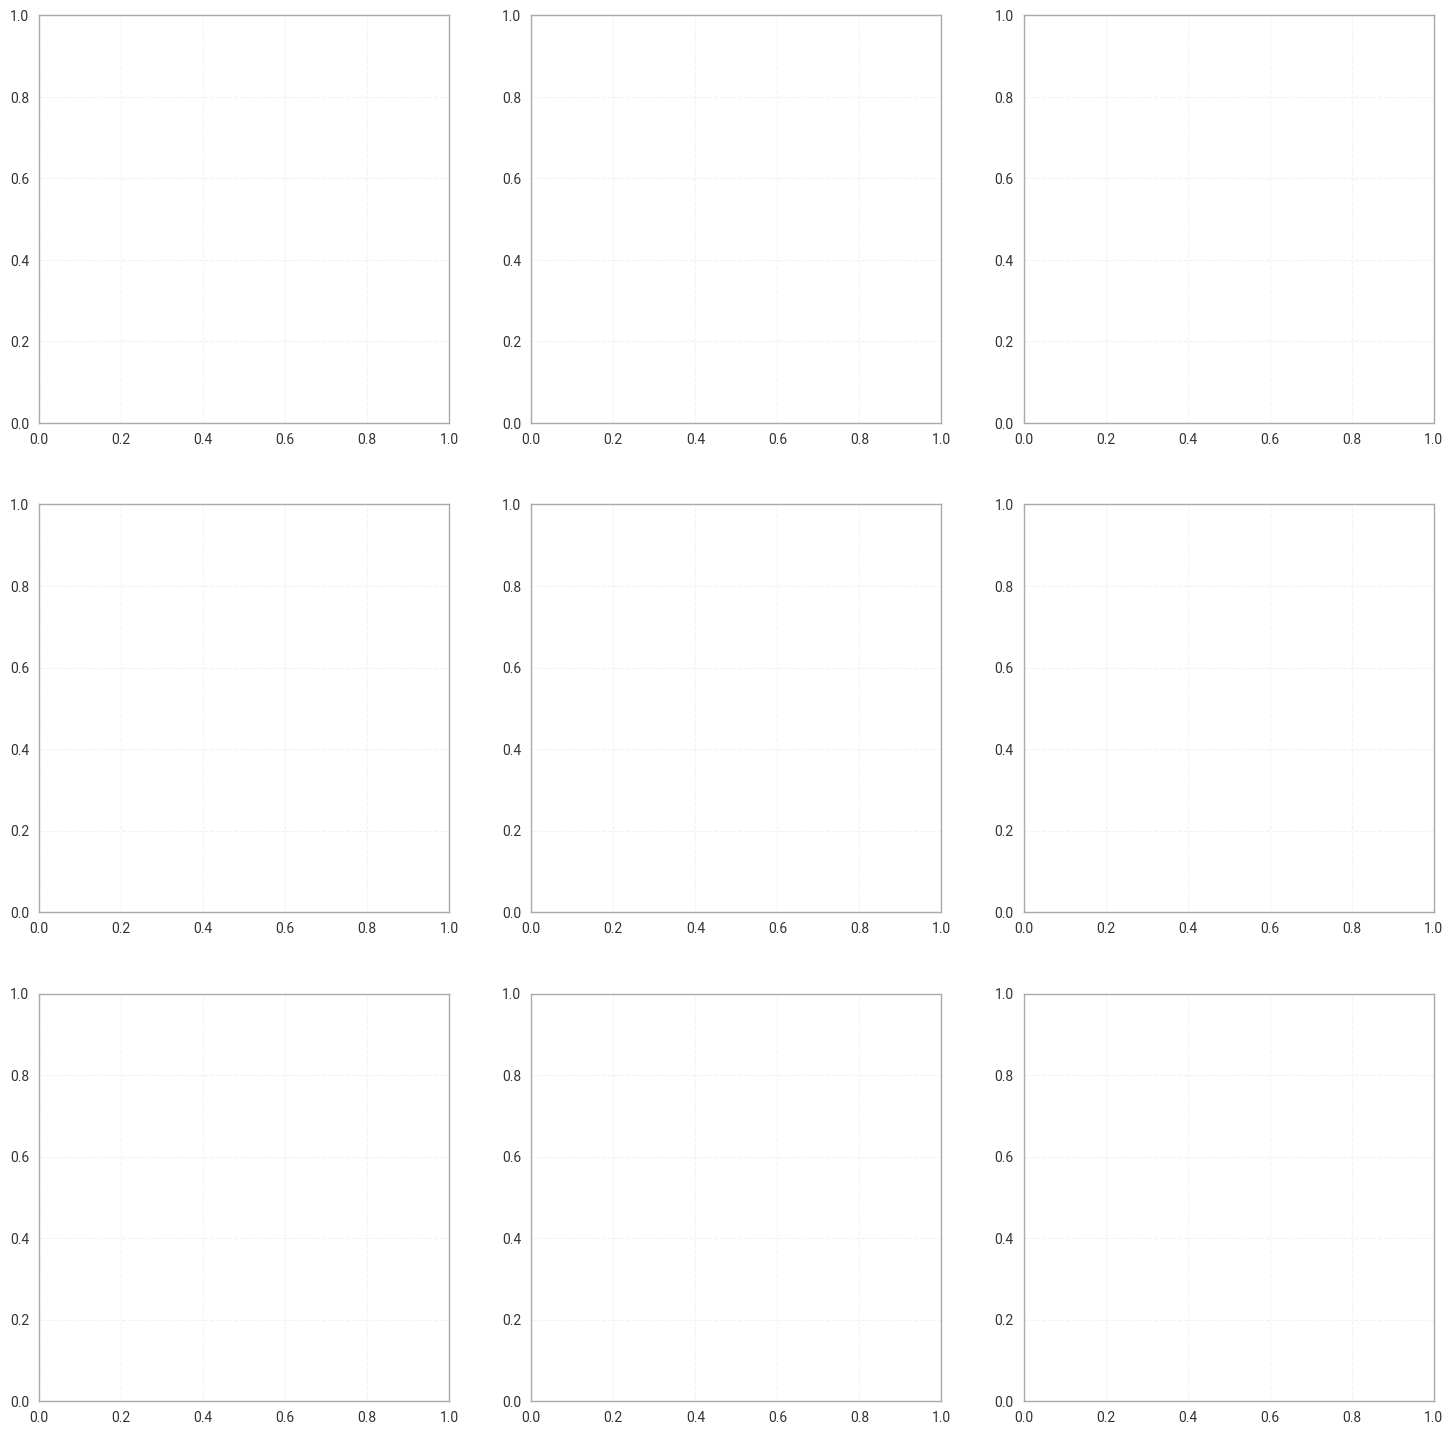

In [232]:
plot_category_confusion_matrices(adjusted_spi_ds.sel(sites=0),addis_point,"SPI",spi_categories) #TODO- Should come after time series.

#### 2.8 Calculating ERA5-Drought SPI (across entire Horn of Africa region)

In [26]:
# Select latitude and longitude box (40 x 40 here)
lon_min, lon_max = 30, 53  
lat_min, lat_max = -5, 18

request_era5_drought_region_template = {
    # The following line generates a string in said format from the chosen year range
    "accumulation_period": ["48"], # Chosen accumulation period
    "version": "1_0", # Version
    "dataset_type": "consolidated_dataset", # Consolidated dataset
    "month": [f"{m:02d}" for m in range(1, 13)], # Months of interest
    "area": [lat_max, lon_min, lat_min, lon_max] # Area of interest
}

spi_region_request1 = {
    "variable": ["standardised_precipitation_index"], # drought index
    "year": [f"{y}" for y in range(1940,1981)],
    "product_type": ["reanalysis"]
} | request_era5_drought_region_template

spi_region_request2 = {
    "variable": ["standardised_precipitation_index"], # drought index
    "year": [f"{y}" for y in range(1981,2025)],
    "product_type": ["reanalysis"]
} | request_era5_drought_region_template


In [31]:
region_era5_spi = ekd.from_source("cds", ID_ERA5_DROUGHT, spi_region_request1, spi_region_request2) # Sends request for this dataset to CDS.
region_era5_spi = region_era5_spi.to_xarray(compat="equals") # Converts to xarray.

  0%|          | 0/2 [00:00<?, ?it/s]

In [32]:
# Subset (latitude is descending in ERA5) - should this be wrapped in a function now?
ds_loc = era5_monthly_mean_reanal.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max),
)

# Accumulate precipitations
precipitation_example_region = accum_var(ds_loc, var = "tp") 

# Select reference precipitation window.
precipitation_example_region_reference = precipitation_example_region.sel(**reference_window) 

# Fit distribution to reference window, extract parameters.
params_fitted_region = fit_monthly_spi(precipitation_example_region_reference)

# Calculate CDF + SPI with parameters.
cdf_region = compute_monthly_spi(precipitation_example_region, params_fitted_region)

# Adjust CDF zero precipitation.
adjusted_cdf_region = zero_precip_adjustment(precipitation_example_region, cdf_region, reference_window)

# Transform adjusted CDF back to SPI
adjusted_spi_region = cdf_to_znorm_transform(adjusted_cdf_region, "SPI")

adjusted_spi_ds_region = adjusted_spi_region.rename({
    "valid_time": "time",
    "latitude": "lat",
    "longitude": "lon"})

era5_spi, adjusted_spi_ds_region = xr.align(region_era5_spi, adjusted_spi_ds_region, join="left")   # only overlapping coords

# # Apply land-sea mask over region. 
# adjusted_spi_ds_region = adjusted_spi_ds_region.where(ls_mask["lsm"]) 

In [33]:
# Calculate difference in ERA5D & Reproduced SPI (Regional 48-Month window).

spi_region_diff = abs(adjusted_spi_ds_region["SPI48"]-era5_spi["SPI48"])
spi_diff_mean = spi_region_diff.mean("time")
spi_diff = spi_region_diff.sel(time = "2024-12-01")

/home/eg6/c3s2-eqc-quality-assessment/.venv/lib/python3.12/site-packages/dask/array/core.py:5189: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(


In [ ]:
# Select one time slice (optional- also mean difference). Best to run overnight.
time_of_interest = "2024-12-01"

map_1 = era5_spi["SPI48"].sel(time = time_of_interest)
map_2 = adjusted_spi_ds_region["SPI48"].sel(time = time_of_interest)

horn = ekp.geo.domains.Domain(
    bbox=[lon_min, lon_max, lat_min, lat_max],
    name="Horn of Africa",
)

# # Plot with EarthKit
SPI_STYLE = Style(cmap='RdBu_r', vmin = -4, vmax = 4, normalize=False)
SPI_DIFF_STYLE = Style(cmap='viridis', vmin = 0, vmax = 1, normalize=False)

# Create figure with 2 columns
fig = ekp.Figure(rows=1, columns=3, size=(12, 6))  

# First subplot (left)
subplot1 = fig.add_map(domain=horn, row=0, column=0)
subplot1.grid_cells(map_1,style=SPI_STYLE)
subplot1.legend(location="right")
subplot1.title(f"ERA5-Drought SPI-48 at {time_of_interest}")

# Second subplot (left)
subplot2 = fig.add_map(domain=horn, row=0, column=1)
subplot2.grid_cells(map_2,style=SPI_STYLE)
subplot2.legend(location="right")
subplot2.title(f"Reproduced SPI-48 at {time_of_interest}")

# First subplot (left)
subplot3 = fig.add_map(domain=horn, row=0, column=2)
subplot3.grid_cells(spi_diff, x=lon_grid, y=lat_grid,style=SPI_DIFF_STYLE)
subplot3.legend(location="right")
subplot3.title("Absolute difference, ERA5-Drought - Reproduced, SPI-48")

# Add decorations
decorate_fig(fig, title = "") 

####  2.9 Comparison of "Probability of Zero Precipitation"
The "probability of zero precipitation" for a given calendar month, in the reference period, per accumulation period may also be imported from the ERA5-Drought dataset, instead of calculating it as we have done. 

You are unable to send an API request to download the data for all accumulation periods at once. If you try to do so, you will find that your xarray only contains the data for the last accumulation period. 

We have written a simple helper function, "era5_api_multiple" that sends separate API requests, concatenating the data into a single xarray, to then use.

In [ ]:
era5_d_prob_spi_zero_all = era5_drought_api_multiple(indicator = "spi", var = "prob_zero", product_type = "reanalysis")

# Rename coordinates to match that of reproduced.
era5_d_prob_spi_zero_all = era5_d_prob_spi_zero_all.rename({"lat": "latitude", "lon":"longitude"})

Months with defined "zero precipitation" are then calculated from the origin dataset.

In [ ]:
# Accumulate precipitation globally.
acc_precip_global = accum_var(era5_monthly_mean_reanal, var = "tp")

# Find probability of zero precipitation across months.
p_zero, weighted_p_zero = zero_precip_prob(acc_precip_global, reference_window)
    
# Find months that fail zero-precipitation quality criteria (> 0.33) in reproduced dataset.
zero_rejection, zero_rejection_agg = zero_precip_rejection(p_zero, ls_mask)

# Find months that fail zero-precipitation quality criteria in reproduced dataset.
era5_zero_rejection, era5_zero_rejection_agg = zero_precip_rejection(era5_d_prob_spi_zero_all, ls_mask)

And a global spatial comparison of the number of zero-precipitation calendar months is made against ERA5-Drought

In [ ]:
accumulation_window = [1]

fig_mpl = quality_flag_spatial_comparison(zero_rejection_agg,era5_zero_rejection_agg,
                                          accumulation_window, "global", "Zero Precipitation") # Zero preecipitation
fig_mpl.show()


We finally show that "probability of zero precipitation months" match for all calendar months at all locations.

In [ ]:
# Calculate statistics
x = np.ravel(p_zero["tp_mm_accum_1m"].where(ls_mask["lsm"]))
y = np.ravel(era5_d_prob_spi_zero_all["prob_zero_1"].where(ls_mask["lsm"]))

p_threshold = 0.33 

x_count = np.count_nonzero(~np.isnan(x))
y_count = np.count_nonzero(~np.isnan(y))

reject_x_count = (x > p_threshold).sum()
reject_y_count = (y > p_threshold).sum()

percent_reject_x = (reject_x_count/x_count)*100
percent_reject_y = (reject_y_count/y_count)*100

In [ ]:
# Create scatter plot
plt.figure(figsize=(8, 6))
hb = plt.scatter(
    x, y,   
)

plt.hlines(y=p_threshold, xmin=0, xmax=p_threshold, colors='g', linestyles='--', linewidth=2)
plt.vlines(x=p_threshold, ymin=0, ymax=p_threshold, colors='g', linestyles='--', linewidth=2)
plt.fill_between([0,p_threshold], 0, p_threshold, facecolor="none", hatch="X", edgecolor="green", linewidth=0.0, label='Acceptance criteria')

# Labels and title
plt.xlabel('Reproduced')
plt.ylabel('ERA5-Drought')
plt.title('Comparison of Probability of Zero Precipitation')
plt.annotate(f"Reproduced rejection freq: {percent_reject_x:.5g}%\n ERA5D rejection freq:{percent_reject_y:.5g}%", xy=(0.5, 0.2))
plt.legend()

# Display plot
plt.show() 
# TODO: Calculate percentage that are the same, ignoring the NaN.

#### 2.10 Comparison of S-W quality indicator.

Quality control is performed by the ERA5-Drought team over the entire dataset. This is done by testing if the calculated distribution of the estimated drought indices over the reference period follows a normal distribution with mean 0 and standard deviation 1. 

This test is performed using the Shapiro-Wilks test for normality [S. S. Shapiro et al, 1965.](https://doi.org/10.1093/biomet/52.3-4.591), with a $\alpha$ = 0.05 on the data in the reference period (1991-2020). 

If the resultant p-value is less than $\alpha$ = 0.05, the corresponding quality parameter is set to 0 (bad), otherwise set to 1 (good). We perform this test over the calculated SPI values, that are adjusted for zero-precipitation. 

In [ ]:
# Select latitude and longitude box (40 x 40 here)
lon_min, lon_max = 30, 53  
lat_min, lat_max = -5, 18

# Subset (latitude is descending in ERA5) - should this be wrapped in a function now?
ds_loc = era5_monthly_mean_reanal.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max))

# Accumulate precipitations
precipitation_example_global = accum_var(ds_loc, var = "tp") 

# Select reference precipitation window.
precipitation_example_global_reference = precipitation_example_global.sel(**reference_window) 

# Fit distribution to reference window, extract parameters.
params_fitted_global = fit_monthly_spi(precipitation_example_global_reference)

# Calculate CDF  with parameters.
cdf_global = compute_monthly_spi(precipitation_example_global, params_fitted_global)

In [ ]:
# Adjust CDF zero precipitation.
adjusted_cdf_global = zero_precip_adjustment(precipitation_example_global, cdf_global, reference_window)

# Transform adjusted CDF back to SPI
adjusted_spi_global = cdf_to_znorm_transform(adjusted_cdf_global, "SPI")

# Apply land-sea mask over region. 
# adjusted_spi_ds_global = adjusted_spi_global.where(ls_mask["lsm"]) 

In [ ]:
pval_spi_global, sig_spi_global = xr_shapiro_test(adjusted_spi_ds_global, reference_window, index_name = "SPI")

sig_spi_agg_global = sig_spi_global.sum(dim = "time") # Aggregate across months.

In [ ]:
accumulation_window = 1

# --- Colormap as you already have ---
beige_to_red = LinearSegmentedColormap.from_list(
    "beige_to_red",
    ["#fbeec2", "#d47a57", "#8b0000"]   # beige → soft red → dark red
)

ZERO_PRECIP_STYLE      = Style(cmap=beige_to_red, vmin=1,  vmax=12,  normalize=False)
BLACK_POINT_STYLE      = Style(cmap=ListedColormap(["black"]), vmin=0, vmax=0.99, normalize=False)
ZERO_PRECIP_DIFF_STYLE = Style(cmap="RdBu_r", vmin=-12, vmax=12, normalize=False)

# ------------------ LEFT PANEL ------------------
da1 = sig_spi_agg_global[f"significance_{accumulation_window}"] # Reproduced
non_ones1 = da1.where(da1 != 0)   # all values except 0
ones1     = da1.where(da1 == 0)   # only values equal to 0

# ------------------ MIDDLE PANEL ------------------
da2 = quality_spi_all_agg[f"significance_{accumulation_window}"].sel(
    lat=slice(lat_max, lat_min),
    lon=slice(lon_min, lon_max)) # ERA5-D

non_ones2 = da2.where(da2 != 0)
ones2     = da2.where(da2 == 0)

In [ ]:
# Create figure with 3 columns
fig = ekp.Figure(rows=1, columns=2)

# ---------- Subplot 1 ----------
subplot1 = fig.add_map(domain="global", row=0, column=0)
mappable1 = subplot1.grid_cells(non_ones1, style=ZERO_PRECIP_STYLE)
subplot1.grid_cells(ones1, style=BLACK_POINT_STYLE, zorder=101)
ax1 = subplot1.ax
ax1.set_title(f"Reproduced — # Months S-W  Rejection ({accumulation_window}‑Month Window)")

# ---------- Subplot 2 ----------
subplot2 = fig.add_map(domain="global", row=0, column=1)
mappable2 = subplot2.grid_cells(non_ones2, style=ZERO_PRECIP_STYLE)
subplot2.grid_cells(ones2, style=BLACK_POINT_STYLE, zorder=101)
ax2 = subplot2.ax
ax2.set_title(f"ERA5 —  # Months S-W  Rejection ({accumulation_window}‑Month Window)")

# ------------------ SHARED FIGURE SETTINGS ------------------
# Set figure size (wide)
fig_mpl = ax1.figure
fig_mpl.set_size_inches(18, 6)

# Shared colorbar for the first two panels — use the mappable from panel 1
cbar12 = fig_mpl.colorbar(
    mappable1,
    ax=[ax1, ax2],
    orientation="horizontal",
    location="bottom",    # remove this line if your Matplotlib is older than 3.6
    fraction=0.06,
    pad=0.08,
    ticks=np.arange(1, 13)
)

cbar12.set_label("Number of months (1–12)")

decorate_fig(fig, title = "") # TODO Make colorbar discrete

You can also import the quality flags from ERA5-Drought, for every calendar month, in the reference period, per accumulation period. 

You are unable to send an API request to download this data for all accumulation periods at once. If you try to do so, you will find that your xarray only contains the data for the last accumulation period (in this case, the 48-month window). 

We have written a simple script that sends separate API requests, concatenating the data into a single xarray, to then use.

In [ ]:
# One location -- reproduced -- keep --
pval_spi, sig_spi = xr_shapiro_test(adjusted_spi_ds, reference_window, index_name = "SPI")
sig_spi_agg = sig_spi.sum(dim = "time") # Aggregate across months.

In [ ]:
quality_spi_all = era5_drought_api_multiple(indicator = "spi", var = "quality", product_type = "reanalysis")
quality_spi_all_agg = quality_spi_all.sum(dim="time")

In [ ]:
quality_spi_addis = quality_spi_all.sel(coords_dict["Addis Ababa, Ethiopia"])
quality_spi_tedd = quality_spi_all.sel(coords_dict["Teddington, United Kingdom"])
quality_spi_denv = quality_spi_all.sel(coords_dict["Denver, USA"])

Significance values are then compared between ERA5-Drought and calculated values.

In [ ]:
xnor_result = quality_spi_addis == sig_spi.sel(sites=0)

# --- Config ---
COLORS = {
    "era5": "#1f77b4",
    "repro": "#ff7f0e",
    "match": "#2ca02c",
}

# --- X locations and bar width for 3 bars per group ---
x = np.arange(len(ACCUMULATION_PERIODS))
n_bars = 3
width = 0.8 / n_bars  # keeps total group width ~0.8

fig, ax = plt.subplots(figsize=(10, 5))

for i, p in enumerate(ACCUMULATION_PERIODS):
    # Existing values (assumed scalar fractions)
    era5_val = float(quality_spi_all_agg[f"significance_{p}"].sel(coords_dict["Addis Ababa, Ethiopia"]).values)
    repro_val = float(sig_spi_agg[f"significance_{p}"].sel(sites=0).values)

    # Match fraction from xnor_result (aggregate over time and normalise)
    mean_true = xnor_result[f"significance_{p}"].sum(dim="time", skipna=True)
    mean_true = float(mean_true.compute())

    # Plot 3 bars: left (ERA5D), center (Reproduced), right (Mismatch)
    ax.bar(
        x[i] - width, era5_val, width,
        label="ERA5-Drought" if i == 0 else None, color=COLORS["era5"]
    )
    ax.bar(
        x[i], repro_val, width,
        label="Reproduced" if i == 0 else None, color=COLORS["repro"]
    )
    ax.bar(
        x[i] + width, mean_true, width,
        label="Match frequency" if i == 0 else None, color=COLORS["match"]
    )

# --- Cosmetics ---
ax.set_xticks(x)
ax.set_xticklabels([str(p) for p in ACCUMULATION_PERIODS])
ax.set_xlabel("Accumulation windows (months)")
ax.set_ylabel("Fraction of months in calendar year")
ax.set_ylim(0, 12)
ax.set_title("Fraction of months passing S-W test & match frequency (for each accumulation window).")
ax.legend(frameon=False)
ax.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.show() 

In [ ]:
# TODO 

#### 2.11 ERA5-Drought SPI vs Reproduced (other regions, Teddington & Denver)

In [ ]:
########################## TEDDINGTON (LONDON) DOWNLOAD ###########################################

tedd_req1 = {
    "variable": ["standardised_precipitation_index"],
    "accumulation_period": [str(p) for p in ACCUMULATION_PERIODS],
    "version": "1_0",
    "dataset_type": "consolidated_dataset",
    "month": [f"{m:02d}" for m in range(1, 13)],
    "area": area_dict["Teddington, United Kingdom"],
    "product_type": ["reanalysis"],
    "year": [str(y) for y in range(1940, 1981)],
}

tedd_req2 = {
    **tedd_req1,
    "year": [str(y) for y in range(1981, 2025)],
}

tedd_src = ekd.from_source("cds", ID_ERA5_DROUGHT, tedd_req1, tedd_req2)
tedd_ds = tedd_src.to_xarray(compat="equals")
tedd_point = tedd_ds.sel(coords_dict["Teddington, United Kingdom"])

########################## DENVER DOWNLOAD ###########################################

denver_req1 = {
    "variable": ["standardised_precipitation_index"],
    "accumulation_period": [str(p) for p in ACCUMULATION_PERIODS],
    "version": "1_0",
    "dataset_type": "consolidated_dataset",
    "month": [f"{m:02d}" for m in range(1, 13)],
    "area": area_dict["Denver, USA"],
    "product_type": ["reanalysis"],
    "year": [str(y) for y in range(1940, 1981)],
}

denver_req2 = {
    **denver_req1,
    "year": [str(y) for y in range(1981, 2025)],
}

denver_src = ekd.from_source("cds", ID_ERA5_DROUGHT, denver_req1, denver_req2)
denver_ds = denver_src.to_xarray(compat="equals")
denv_point = denver_ds.sel(coords_dict["Denver, USA"])

To ensure our comparison is not biased for one location, we make a time-serise comparison also for sites at Teddington (London) and Denver (USA)

In [ ]:
plot_index_comparison_side_by_side("SPI", tedd_point, adjusted_spi_ds.sel(sites=1),spi_categories) # takes a while

In [ ]:
plot_index_comparison_side_by_side("SPI", denv_point, adjusted_spi_ds.sel(sites=2),spi_categories) # takes a while

We also compute a table of median & absolute median differences for these two locations.

In [ ]:
spi_results_diff_tedd =  comparison_monthly_statistics(tedd_point, adjusted_spi_ds.sel(sites=1), "SPI", ACCUMULATION_PERIODS) # takes a while
spi_results_diff_denv =  comparison_monthly_statistics(denv_point, adjusted_spi_ds.sel(sites=2), "SPI", ACCUMULATION_PERIODS) # takes a while

In [ ]:
display_monthly_statistics(spi_results_diff_denv,"median", "Median Difference - Denver")
display_monthly_statistics(spi_results_diff_tedd,"median", "Median Difference - Teddington")

In [ ]:
display_monthly_statistics(spi_results_diff_denv,"abs_median", "Absolute Median Difference - Denver") 
display_monthly_statistics(spi_results_diff_tedd,"abs_median", "Absolute Median Difference - Teddington") 

Along with a comparison of the categorisation of drought-severity at these locations.

In [ ]:
plot_category_confusion_matrices(adjusted_spi_ds.sel(sites=1),tedd_point,"SPI",spi_categories) # TODO Give plot overall title with location
# TODO Make shading clearer

In [ ]:
plot_category_confusion_matrices(adjusted_spi_ds.sel(sites=2),denv_point,"SPI",spi_categories) # TODO Give plot overall title with location
#TODO: Colour them by fraction horizontally but leave absolute numbers

(section-spei)=
###  4. Calculate SPEI from ERA5 reanalysis data.
The steps to calculating the SPEI-index are exactly the same as calculating the SPI index, with the only modification being that the SPEI integrates both the precipitation and potential evapotranspiration (PET) data, and uses a different statistical distribution.

#### 3.0 Importing monthly-average precipitation &  potential evaporation data.

We import the monthly-mean precipitation & potential evaporation data from the "ERA5 monthly-averaged data on single levels from 1940 to present" dataset. (https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download)

In case you start from this section, we also import the monthly-mean preciptiation data too from the previous SPI section.

In [43]:
era5_tp_moda_request = {
    "param": "228.128",       # Variable: Total precipitation
    "stream": "moda",         # Data stream: Monthly mean reanalysis
} | request_era5_template

# Download precipitation data and convert to desired format
era5_tp_monthly = ekd.from_source("cds", ID_ERA5, era5_tp_moda_request)  # Download as field list
era5_tp_monthly = era5_tp_monthly.to_xarray(compat="equals")  # Convert to xarray dataset
era5_tp_monthly =  era5_tp_monthly.assign_coords(
    longitude=((era5_tp_monthly.longitude - 180) % 360) - 180).sortby("longitude")
era5_tp_monthly = rechunk(era5_tp_monthly)  # Re-chunk for speed gain in fitting

In [44]:
era5_pev_moda_request = {
    "param": "251.228",       # Variable: Potential evaporation (pev)
    "stream": "moda",         # Data stream: Monthly mean reanalysis
} | request_era5_template

# Download data and convert to desired format
era5_pev_monthly = ekd.from_source("cds", ID_ERA5, era5_pev_moda_request)  # Download as field list
era5_pev_monthly = era5_pev_monthly.to_xarray(compat="equals")  # Convert to xarray dataset
era5_pev_monthly =  era5_pev_monthly.assign_coords(
    longitude=((era5_pev_monthly.longitude - 180) % 360) - 180).sortby("longitude")
era5_pev_monthly = rechunk(era5_pev_monthly)  # Re-chunk for speed gain in fitting

#### 3.1 Calculate accumulated water balance (P-PET) for different windows.

A time series of both precipitation & potential evaporation (PET/PEV) from one grid point are extracted and the precipitation & potential evaporation are accumulated over the previous $n$ months using a moving window, analogous to the SPI.

Note, [ECMWF convention](https://codes.ecmwf.int/grib/param-db/182) is that negative values for PEV/PET indicate evaporation, whereas positive values indicate condensation. Since the ECMWF convention is that a negative value of PET indicates evaporation, care must be taken when subtracting the precipitation (P) by the potential evaporation (PEV/PET).

The negative of PEV/PET must be applied, $P − (−PET) = P + PET$ in this case. This approach aligns with the definition of the water balance, where a negative water balance value indicates that more water is potentially being transferred to the atmosphere. 

In [55]:
# Take difference (P- (-PET)) and then accumulate
era5_wb_monthly = era5_pev_monthly["pev"] - (- era5_tp_monthly["tp"])
era5_wb_monthly = era5_wb_monthly.rename("wb")
era5_wb_monthly = era5_wb_monthly.to_dataset()
era5_wb_example_sites = era5_wb_monthly.sel(latitude=xr.DataArray(lats, dims="sites"),
                     longitude=xr.DataArray(lons, dims="sites"))

# Perform the accumulation for each accumulation period at single location
wb_example_site = accum_var(era5_wb_example_sites, "wb")

The plot below illustrates the seasonal water balance for a country like Ethiopia, where periods of high evapotranspiration exceed precipitation, resulting in a negative water balance. Conversely, during wetter months, precipitation surpasses evapotranspiration, producing a surplus of available water.

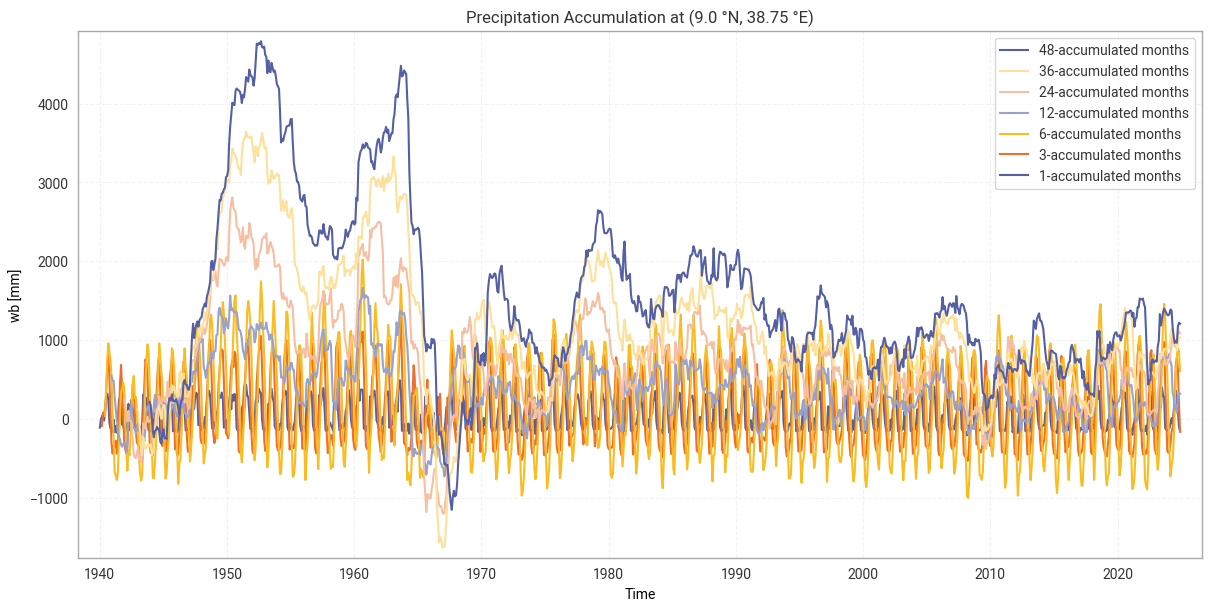

In [56]:
fig, ax = plot_accumulation("wb", wb_example_site.sel(sites=0), sites_dict["Addis Ababa, Ethiopia"])
plt.show()

#### 3.2 Calculate SPEI Index time-series at location (Addis Ababa)

The general log-logistic distribution [reference] is fitted only to the data within the reference period (1991-2020), similar to the gamma distribution being fitted in the calculation of the SPI-index. A separate distribution is fitted for each calendar month per accumulation window.

This fitting is done with the [scipy.stats.genlogistic](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genlogistic.html) object in Python. Three parameters are then outputted per calendar month, per accumulation period: the shape (), location () and scale () parameter.

In [57]:
# Fit log logistic distributions
log_params_fitted = fit_monthly_spei(wb_example_site.sel(**reference_window))

Similar to the calculation for the SPI index, the three parameters from the fitted general log-logistic distribution are taken and the cumulative distribution function (CDF) is calculated up to the accumulated water balance, from the probability distribution function (PDF).

As $ P − PET $ is barely identical to 0, no modifications analogous to the SPI such as adjusting for zero precipitation, are required.

In [183]:
# Compute CDF series
cdf_spei_ds = compute_monthly_spei(wb_example_site, log_params_fitted)
# Compute SPEI series
spei_ds = cdf_to_znorm_transform(cdf_spei_ds , "SPEI")

#### 3.3 Comparison of ERA5-Drought & Reproduced SPEI-index (Addis Ababa, Ethiopia)

In [236]:
spei_categories = [
    (-100,  -2.33, "Extremely dry",  "#6E0000"),  # dark red
    (-2.32, -1.65, "Severely dry",   "#C22E1A"),  # red
    (-1.64, -1.28, "Moderately dry", "#E95B26"),  # orange
    (-1.27, -0.84, "Mildly dry",     "#F9C62F"),  # yellow
    (-0.83,  0.83, "Near-normal",    "#B9F376"),  # light green
    (0.84,   1.27, "Mildly wet",     "#3CF5E8"),  # cyan
    (1.28,   1.64, "Moderately wet", "#33A2EA"),  # medium blue
    (1.65,   2.32, "Severely wet",   "#1C4DC9"),  # strong blue
    (2.33,   100,  "Extremely wet",  "#08146A"),  # very dark navy
]

In [ ]:
spei_addis_req1 = {
    "variable": ["standardised_precipitation_evapotranspiration_index"],
    "accumulation_period": [str(p) for p in ACCUMULATION_PERIODS],
    "version": "1_0",
    "dataset_type": "consolidated_dataset",
    "month": [f"{m:02d}" for m in range(1, 13)],
    "area": area_dict["Addis Ababa, Ethiopia"],
    "product_type": ["reanalysis"],
    "year": [str(y) for y in range(1940, 1981)],
}

spei_addis_req2 = {
    **spei_addis_req1,
    "year": [str(y) for y in range(1981, 2025)],
}

spei_addis_src = ekd.from_source("cds", ID_ERA5_DROUGHT, spei_addis_req1, spei_addis_req2)
spei_addis_ds = spei_addis_src.to_xarray(compat="equals")
spei_addis_point = spei_addis_ds.sel(sites_dict["Addis Ababa, Ethiopia"])

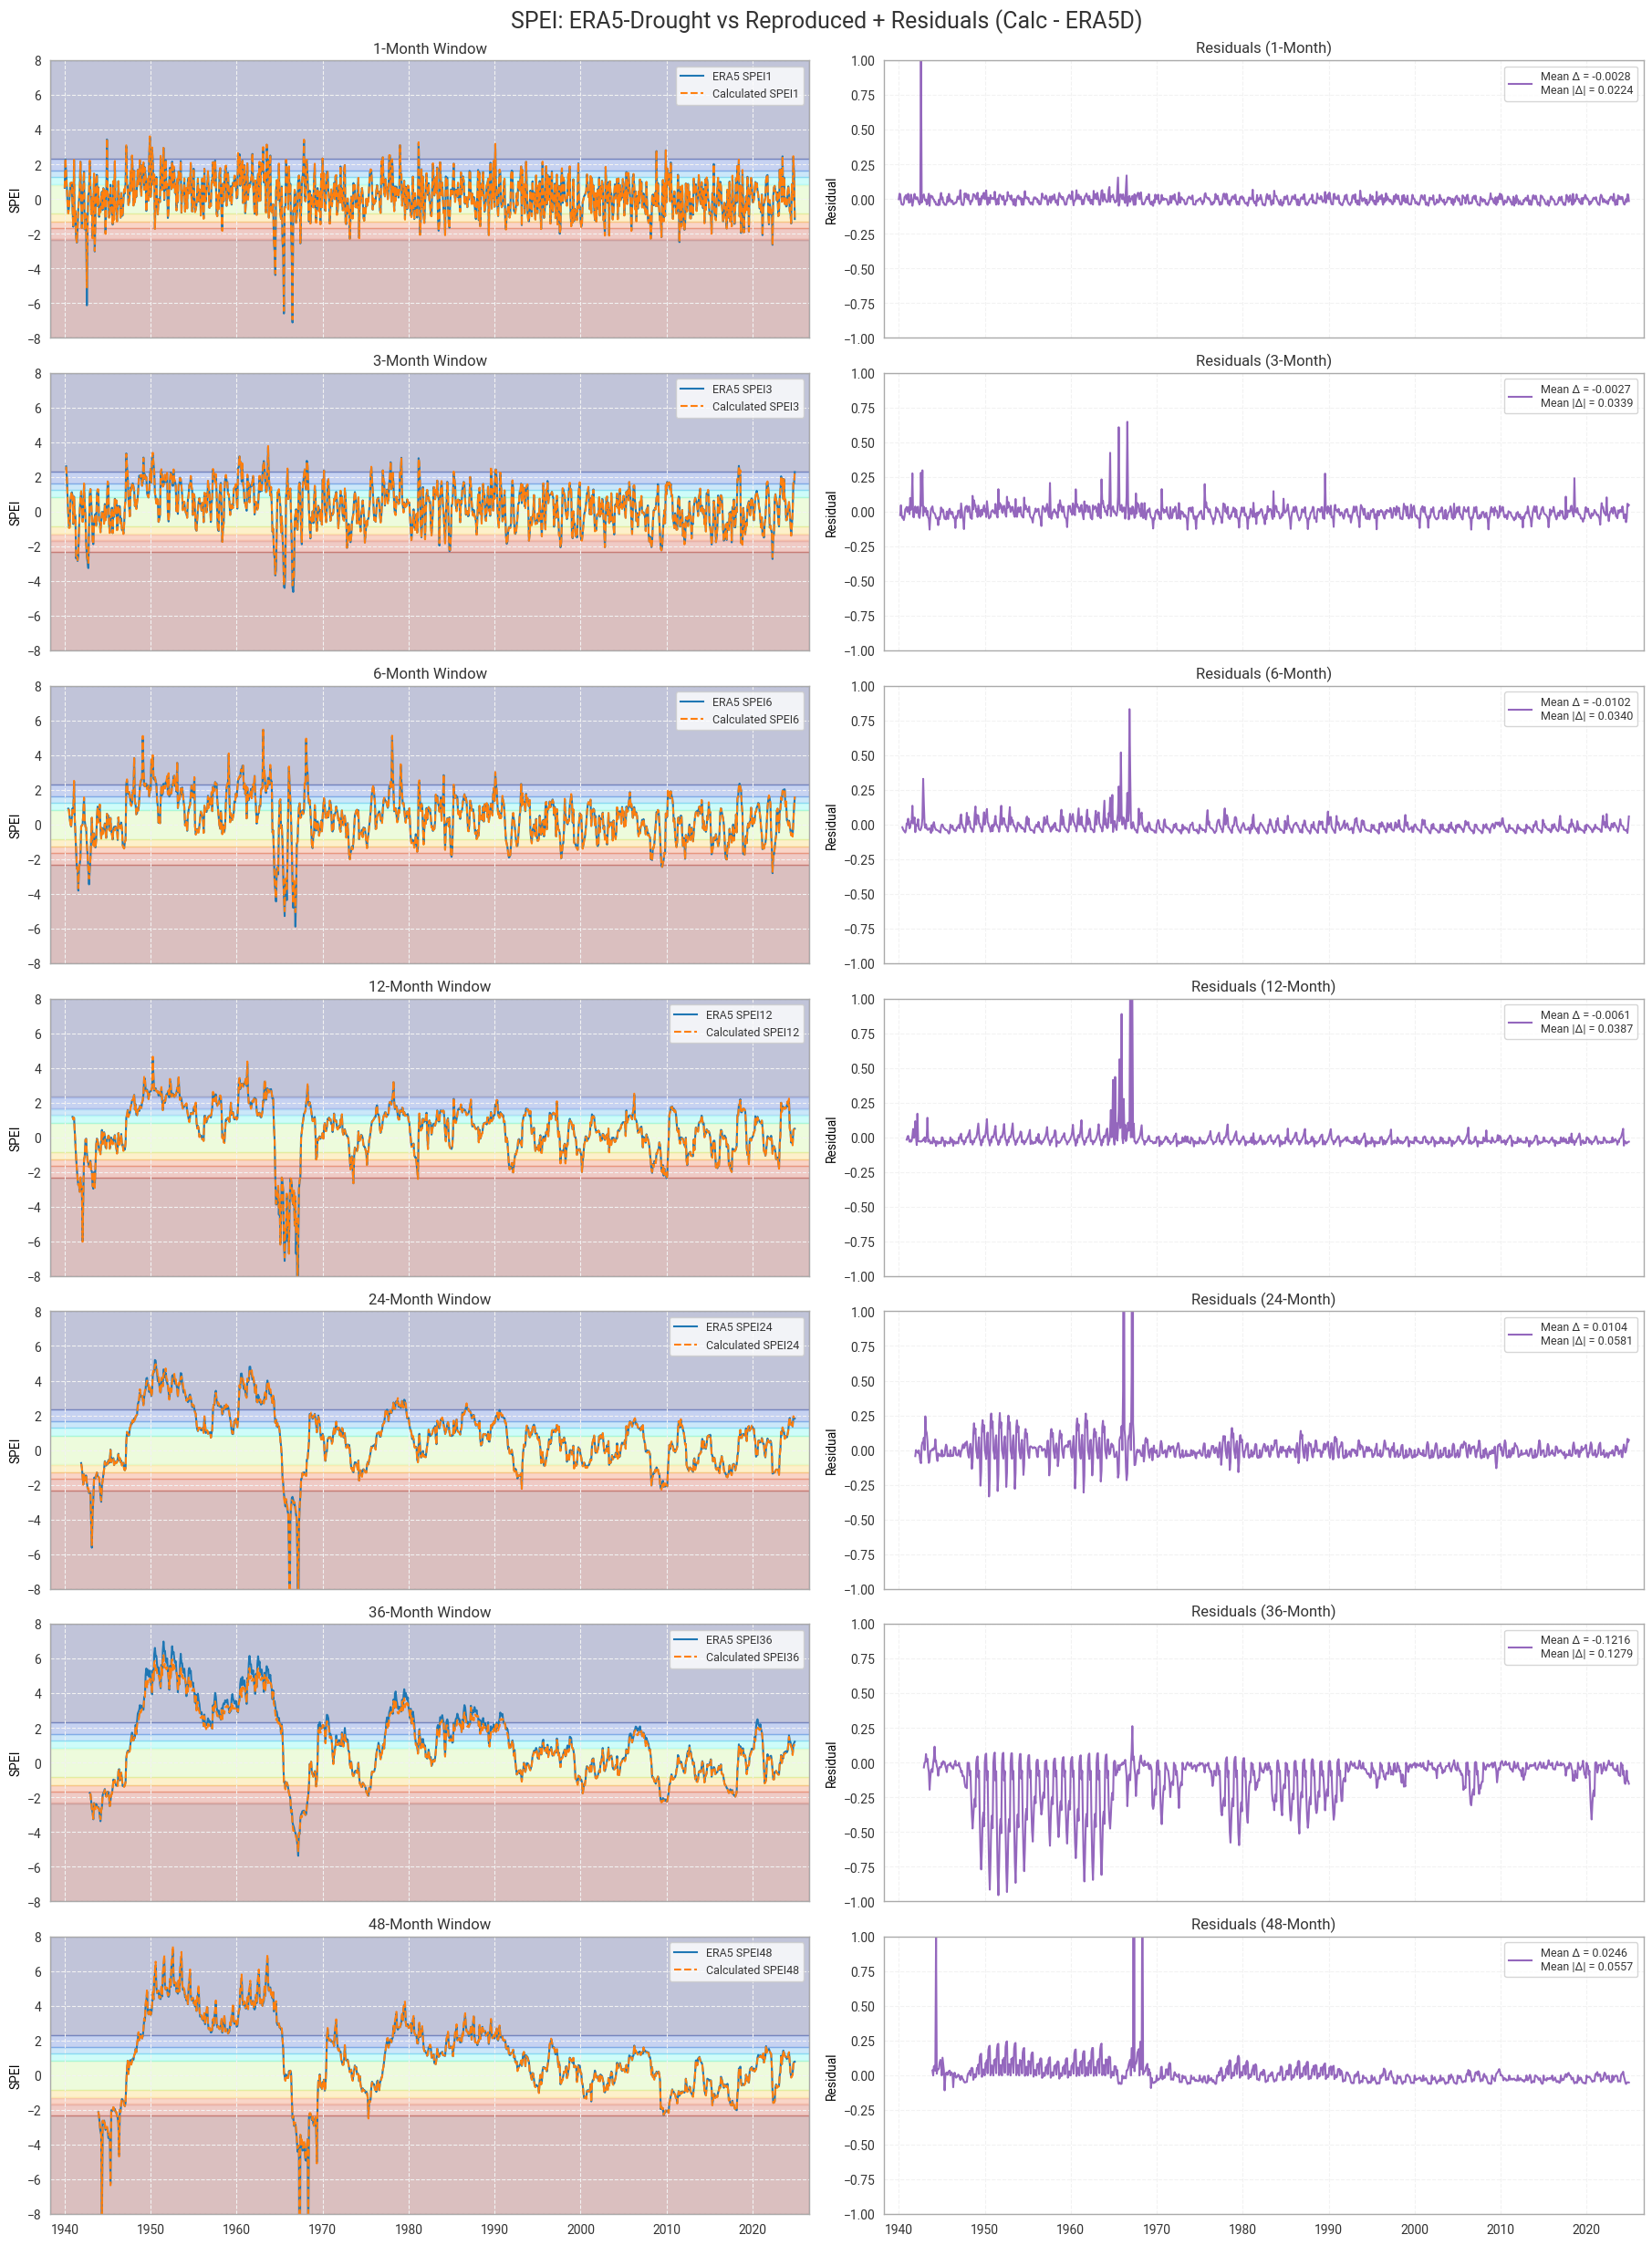

In [223]:
# Plot a time series comparison at Addis Ababa, Ethiopia
plot_index_comparison_side_by_side("SPEI", spei_addis_point, spei_ds.sel(sites=0),spei_categories) # takes a while

In [ ]:
# Calculate quantitative absolute median and absolute median difference. 
spei_results_diff_addis = comparison_monthly_statistics(spei_addis_point, spei_ds.sel(sites=0), "SPEI", ACCUMULATION_PERIODS) # takes a while

In [ ]:
# Display median difference
display_monthly_statistics(spei_results_diff_addis, "median", "SPEI - Median Difference - Addis Ababa")
# Display median absolute difference
display_monthly_statistics(spi_results_diff_addis, "abs_median", "SPEI - Absolute Median Difference - Addis Ababa")

#### 3.4 ERA5-Drought vs Reproduced SPEI (discrepancy in categorisation)

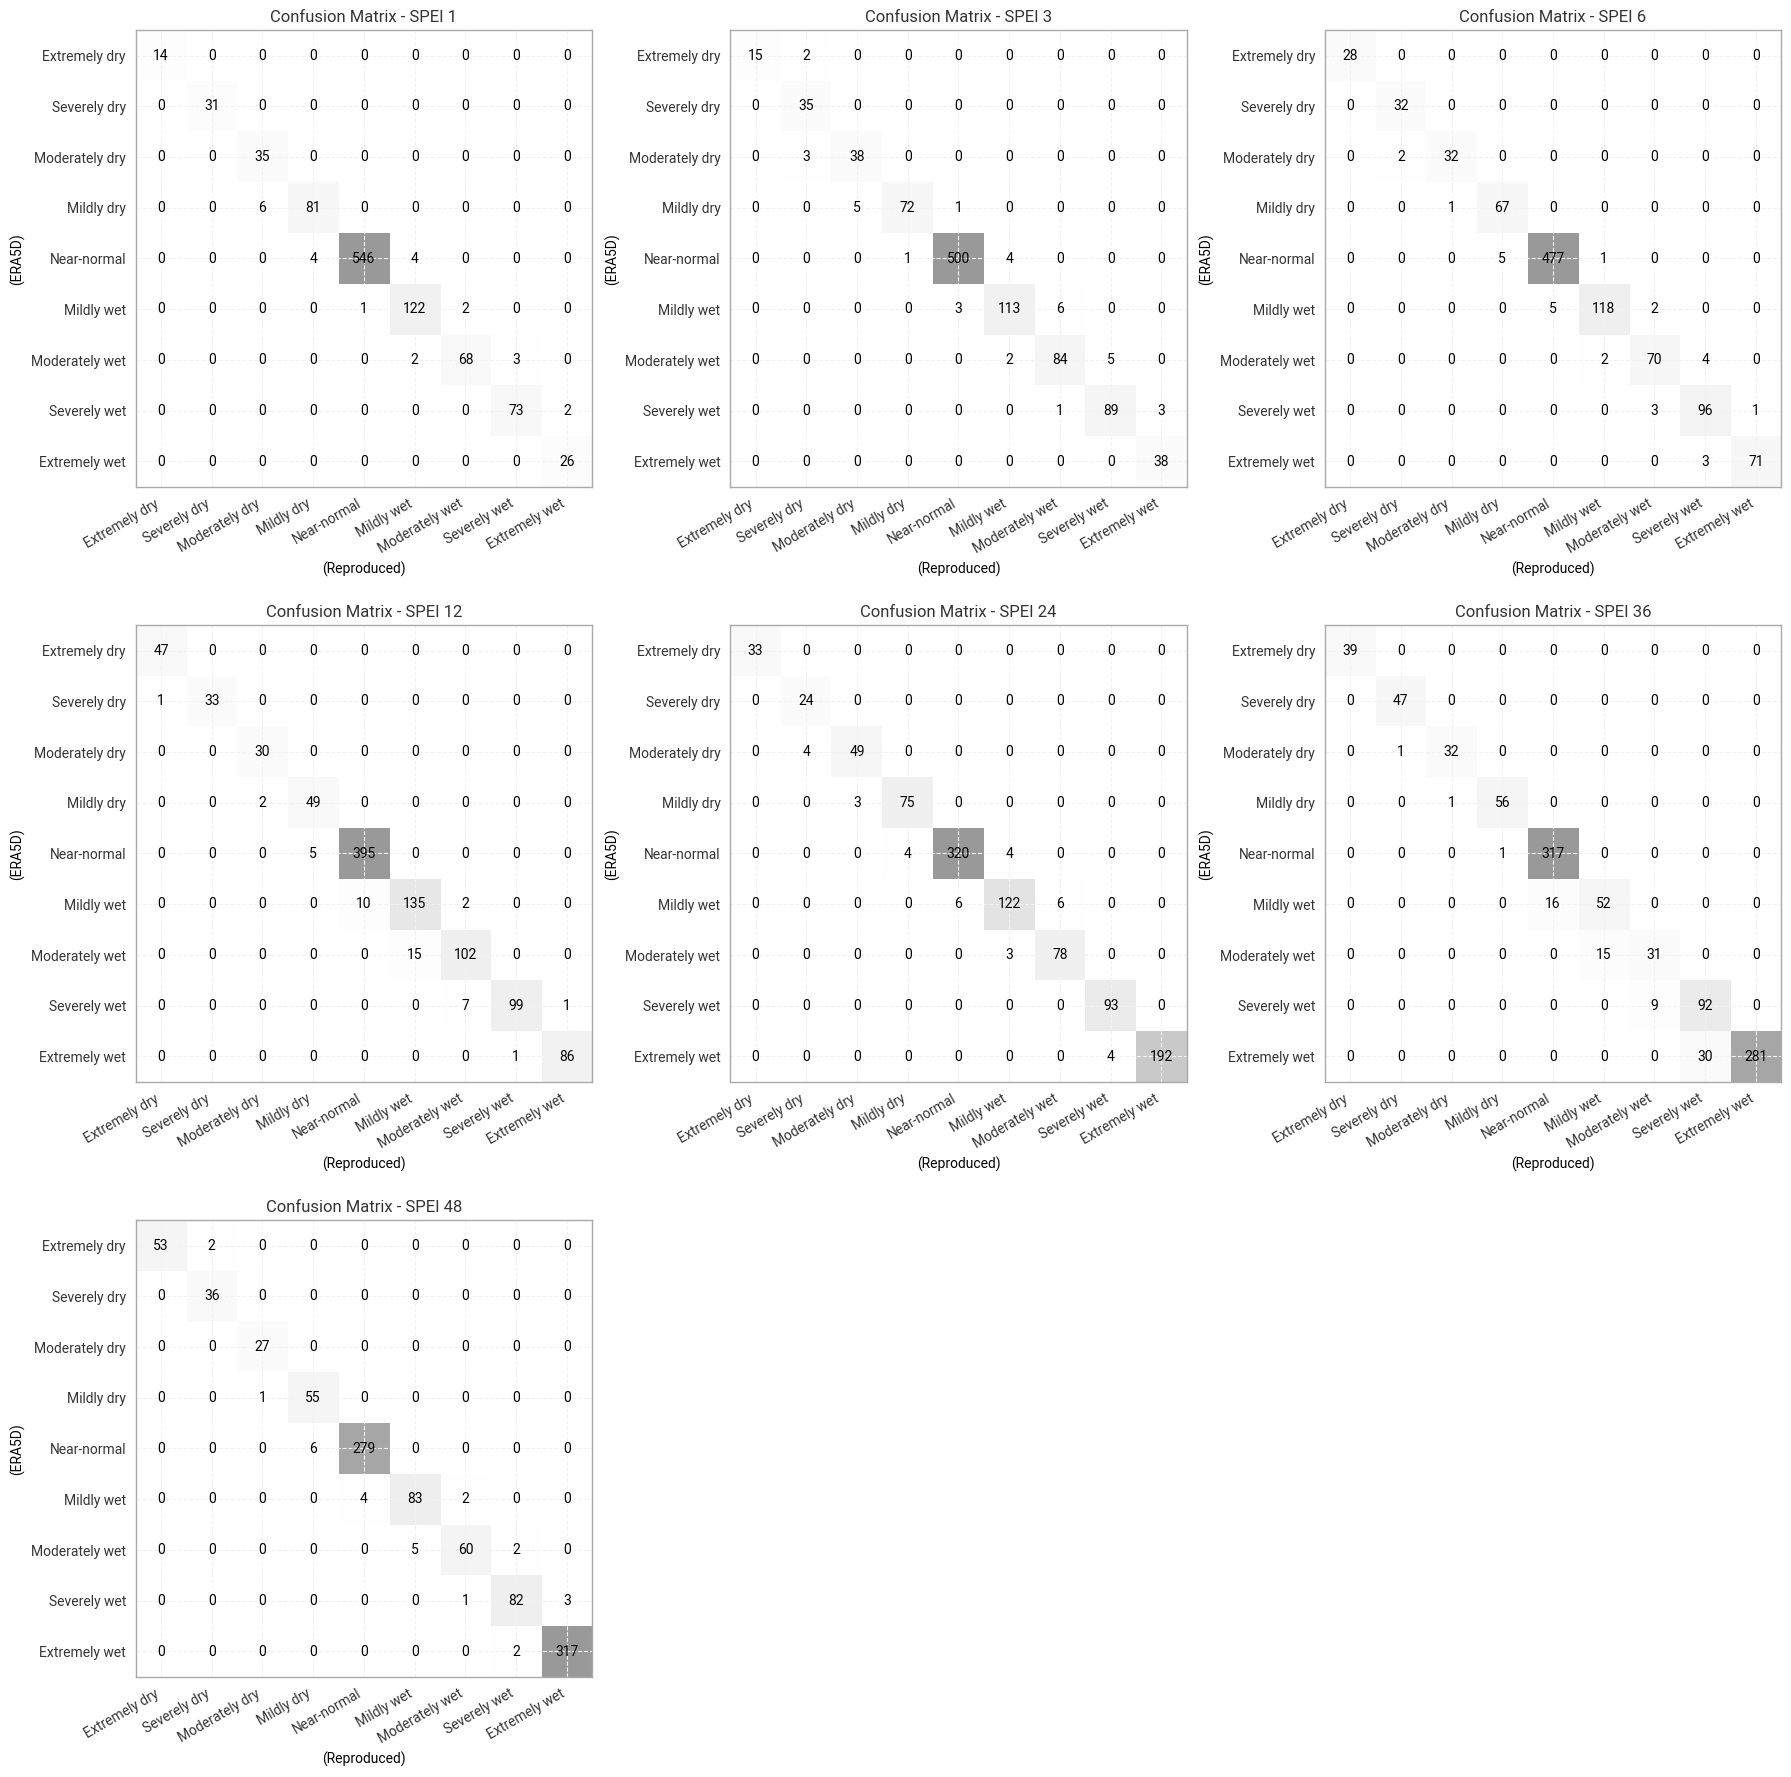

In [327]:
plot_category_confusion_matrices(spei_ds.sel(sites=0),spei_addis_point,"SPEI",spei_categories)

#### 3.5 Comparison of ERA5-Drought & Reproduced SPEI-index over region (Horn of Africa)

In [ ]:
spei_region_request1 = {
    "variable": ["standardised_precipitation_evaporatranspiration_index"], # drought index
    "year": [f"{y}" for y in range(1940,1981)],
    "product_type": ["reanalysis"]
} | request_era5_drought_region_template

spei_region_request2 = {
    "variable": ["standardised_precipitation_evaporatranspiration_index"], # drought index
    "year": [f"{y}" for y in range(1981,2025)],
    "product_type": ["reanalysis"]
} | request_era5_drought_region_template

era5_spei = ekd.from_source("cds", dataset, spei_region_request1, spei_region_request2) # Sends request for this dataset to CDS.
era5_spei = era5_spei.to_xarray(compat="equals") # Converts to xarray.

In [ ]:
# Subset (latitude is descending in ERA5) - should this be wrapped in a function now?
ds_loc = era5_monthly_mean_wb_reanal.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max),
)

# Accumulate water balance
wb_example_region = accum_var(ds_loc, var = "wb") 

# Select reference precipitation window.
wb_example_region_reference = wb_example_region.sel(**reference_window) 

# Fit distribution to reference window, extract parameters.
log_params_fitted_region = fit_monthly_spei(wb_example_region_reference)

# Calculate CDF + SPEI with parameters.
cdf_spei_region = compute_monthly_spei(wb_example_region, log_params_fitted_region)

# Transform CDF to SPEI
spei_region = cdf_to_znorm_transform(adjusted_cdf_region, "SPEI")

spei_region = spei_region.rename({
    "valid_time": "time",
    "latitude": "lat",
    "longitude": "lon"})

era5_spei, spei_region = xr.align(era5_spei, spei_region, join="left")   # only overlapping coords

# # Apply land-sea mask over region. 
# spei_region = spei_region.where(ls_mask["lsm"]) 

In [ ]:
# Select one time slice and one ensemble
map_1 = era5_spei["SPI48"].sel(time = "2024-12-01")
map_2 = spei_region["SPI48"].sel(time = "2024-12-01")

horn = domains.Domain.from_bbox(
    bbox=[30, 53, -5, 18],
    name="Horn of Africa",
)

# # Plot with EarthKit
SPI_STYLE = Style(cmap='RdBu_r', vmin = -4, vmax = 4, normalize=False)
SPI_DIFF_STYLE = Style(cmap='viridis', vmin = 0, vmax = 1, normalize=False)

# Create figure with 2 columns
fig = ekp.Figure(rows=1, columns=3, size=(12, 6))  

# First subplot (left)
subplot1 = fig.add_map(domain=horn, row=0, column=0)
subplot1.grid_cells(map_1,style=SPI_STYLE)
subplot1.legend(location="right")
subplot1.title("ERA5-Drought SPI-48 at 2024-12-01")

# Second subplot (left)
subplot2 = fig.add_map(domain=horn, row=0, column=1)
subplot2.grid_cells(map_2,style=SPI_STYLE)
subplot2.legend(location="right")
subplot2.title("Reproduced SPI-48 at 2024-12-01")

# First subplot (left)
subplot3 = fig.add_map(domain=horn, row=0, column=2)
subplot3.grid_cells(spi_diff, x=lon_grid, y=lat_grid,style=SPI_DIFF_STYLE)
subplot3.legend(location="right")
subplot3.title("Absolute difference, ERA5-Drought - Reproduced, SPI-48")

# Add decorations
fig.land()
fig.coastlines()
fig.borders()
fig.gridlines()
fig.show()

#### 3.6 Comparison of S-W test on SPEI data.

In [106]:
pval_spei, sig_spei = xr_shapiro_test(spei_ds.sel(sites=0), reference_window, index_name = "SPEI")
sig_spei_aggregated= sig_spei.sum(dim = "time")/12 # Aggregate across months.

Quality flags are imported from ERA5-Drought, for every calendar month, in the reference period, per accumulation period for the SPEI index.

You are unable to send an API request to download this data for all accumulation periods at once. We have written a simple script that sends separate API requests, concatenating the data into a single xarray, to then use.

In [108]:
era5_quality_spei_global = era5_drought_api_multiple(indicator = "spei", var = "quality", product_type = "reanalysis")
era5_quality_spei_global_agg = era5_quality_spei_global.sum(dim="time")

In [109]:
era5_quality_spei_addis = era5_quality_spei_global.sel(sites_dict["Addis Ababa, Ethiopia"])
era5_quality_spei_tedd = era5_quality_spei_global.sel(sites_dict["Teddington, United Kingdom"])
era5_quality_spei_denv = era5_quality_spei_global.sel(sites_dict["Denver, USA"])

era5_sig_spei_addis_agg = era5_quality_spei_global_agg.sel(sites_dict["Addis Ababa, Ethiopia"])
era5_sig_spei_tedd_agg = era5_quality_spei_global_agg.sel(sites_dict["Teddington, United Kingdom"])
era5_sig_spei_denv_agg = era5_quality_spei_global_agg.sel(sites_dict["Denver, USA"])

The calculated Shapiro-Wilks significance values are then compared with those from ERA5.

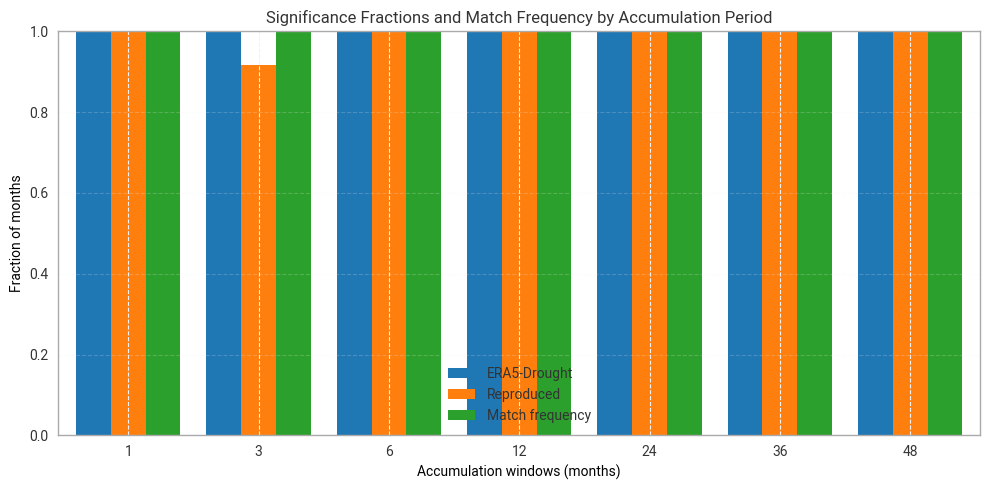

In [112]:
# XNOR Result 
xnor_spei_result = era5_quality_spei_addis == sig_spei

#TODO: Wrap up all code in the function.

# --- Config ---
COLORS = {
    "era5": "#1f77b4",
    "repro": "#ff7f0e",
    "match": "#2ca02c",
}

# --- X locations and bar width for 3 bars per group ---
x = np.arange(len(ACCUMULATION_PERIODS))
n_bars = 3
width = 0.8 / n_bars  # keeps total group width ~0.8

fig, ax = plt.subplots(figsize=(10, 5))

for i, p in enumerate(ACCUMULATION_PERIODS):
    # Existing values (assumed scalar fractions)
    era5_val = float(era5_sig_spei_addis_agg[f"significance_{p}"].values)
    repro_val = float(sig_spei_aggregated[f"significance_{p}"].values)

    # Mismatch fraction from xnor_result (aggregate over time and normalize)
    mean_true = xnor_spei_result[f"significance_{p}"].mean(dim="time", skipna=True)
    mean_true = float(mean_true.compute())

    # Plot 3 bars: left (ERA5D), center (Reproduced), right (Mismatch)
    ax.bar(
        x[i] - width, era5_val, width,
        label="ERA5-Drought" if i == 0 else None, color=COLORS["era5"]
    )
    ax.bar(
        x[i], repro_val, width,
        label="Reproduced" if i == 0 else None, color=COLORS["repro"]
    )
    ax.bar(
        x[i] + width, mean_true, width,
        label="Match frequency" if i == 0 else None, color=COLORS["match"]
    )

# --- Cosmetics ---
ax.set_xticks(x)
ax.set_xticklabels([str(p) for p in ACCUMULATION_PERIODS])
ax.set_xlabel("Accumulation windows (months)")
ax.set_ylabel("Fraction of months")
ax.set_ylim(0, 1)
ax.set_title("Significance Fractions and Match Frequency by Accumulation Period")
ax.legend(frameon=False)
ax.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.show()

#### 3.7 Comparison of ERA5-Drought & Reproduced SPEI-index with quality flags (Addis Ababa, Ethiopia)

In [229]:
spei_ds_addis_masked = apply_sw_quality_mask(era5_quality_spei_addis, spei_ds.sel(sites=0), "SPEI")
era5_masked = apply_sw_quality_mask(era5_quality_spei_addis, spei_addis_point, "SPEI")

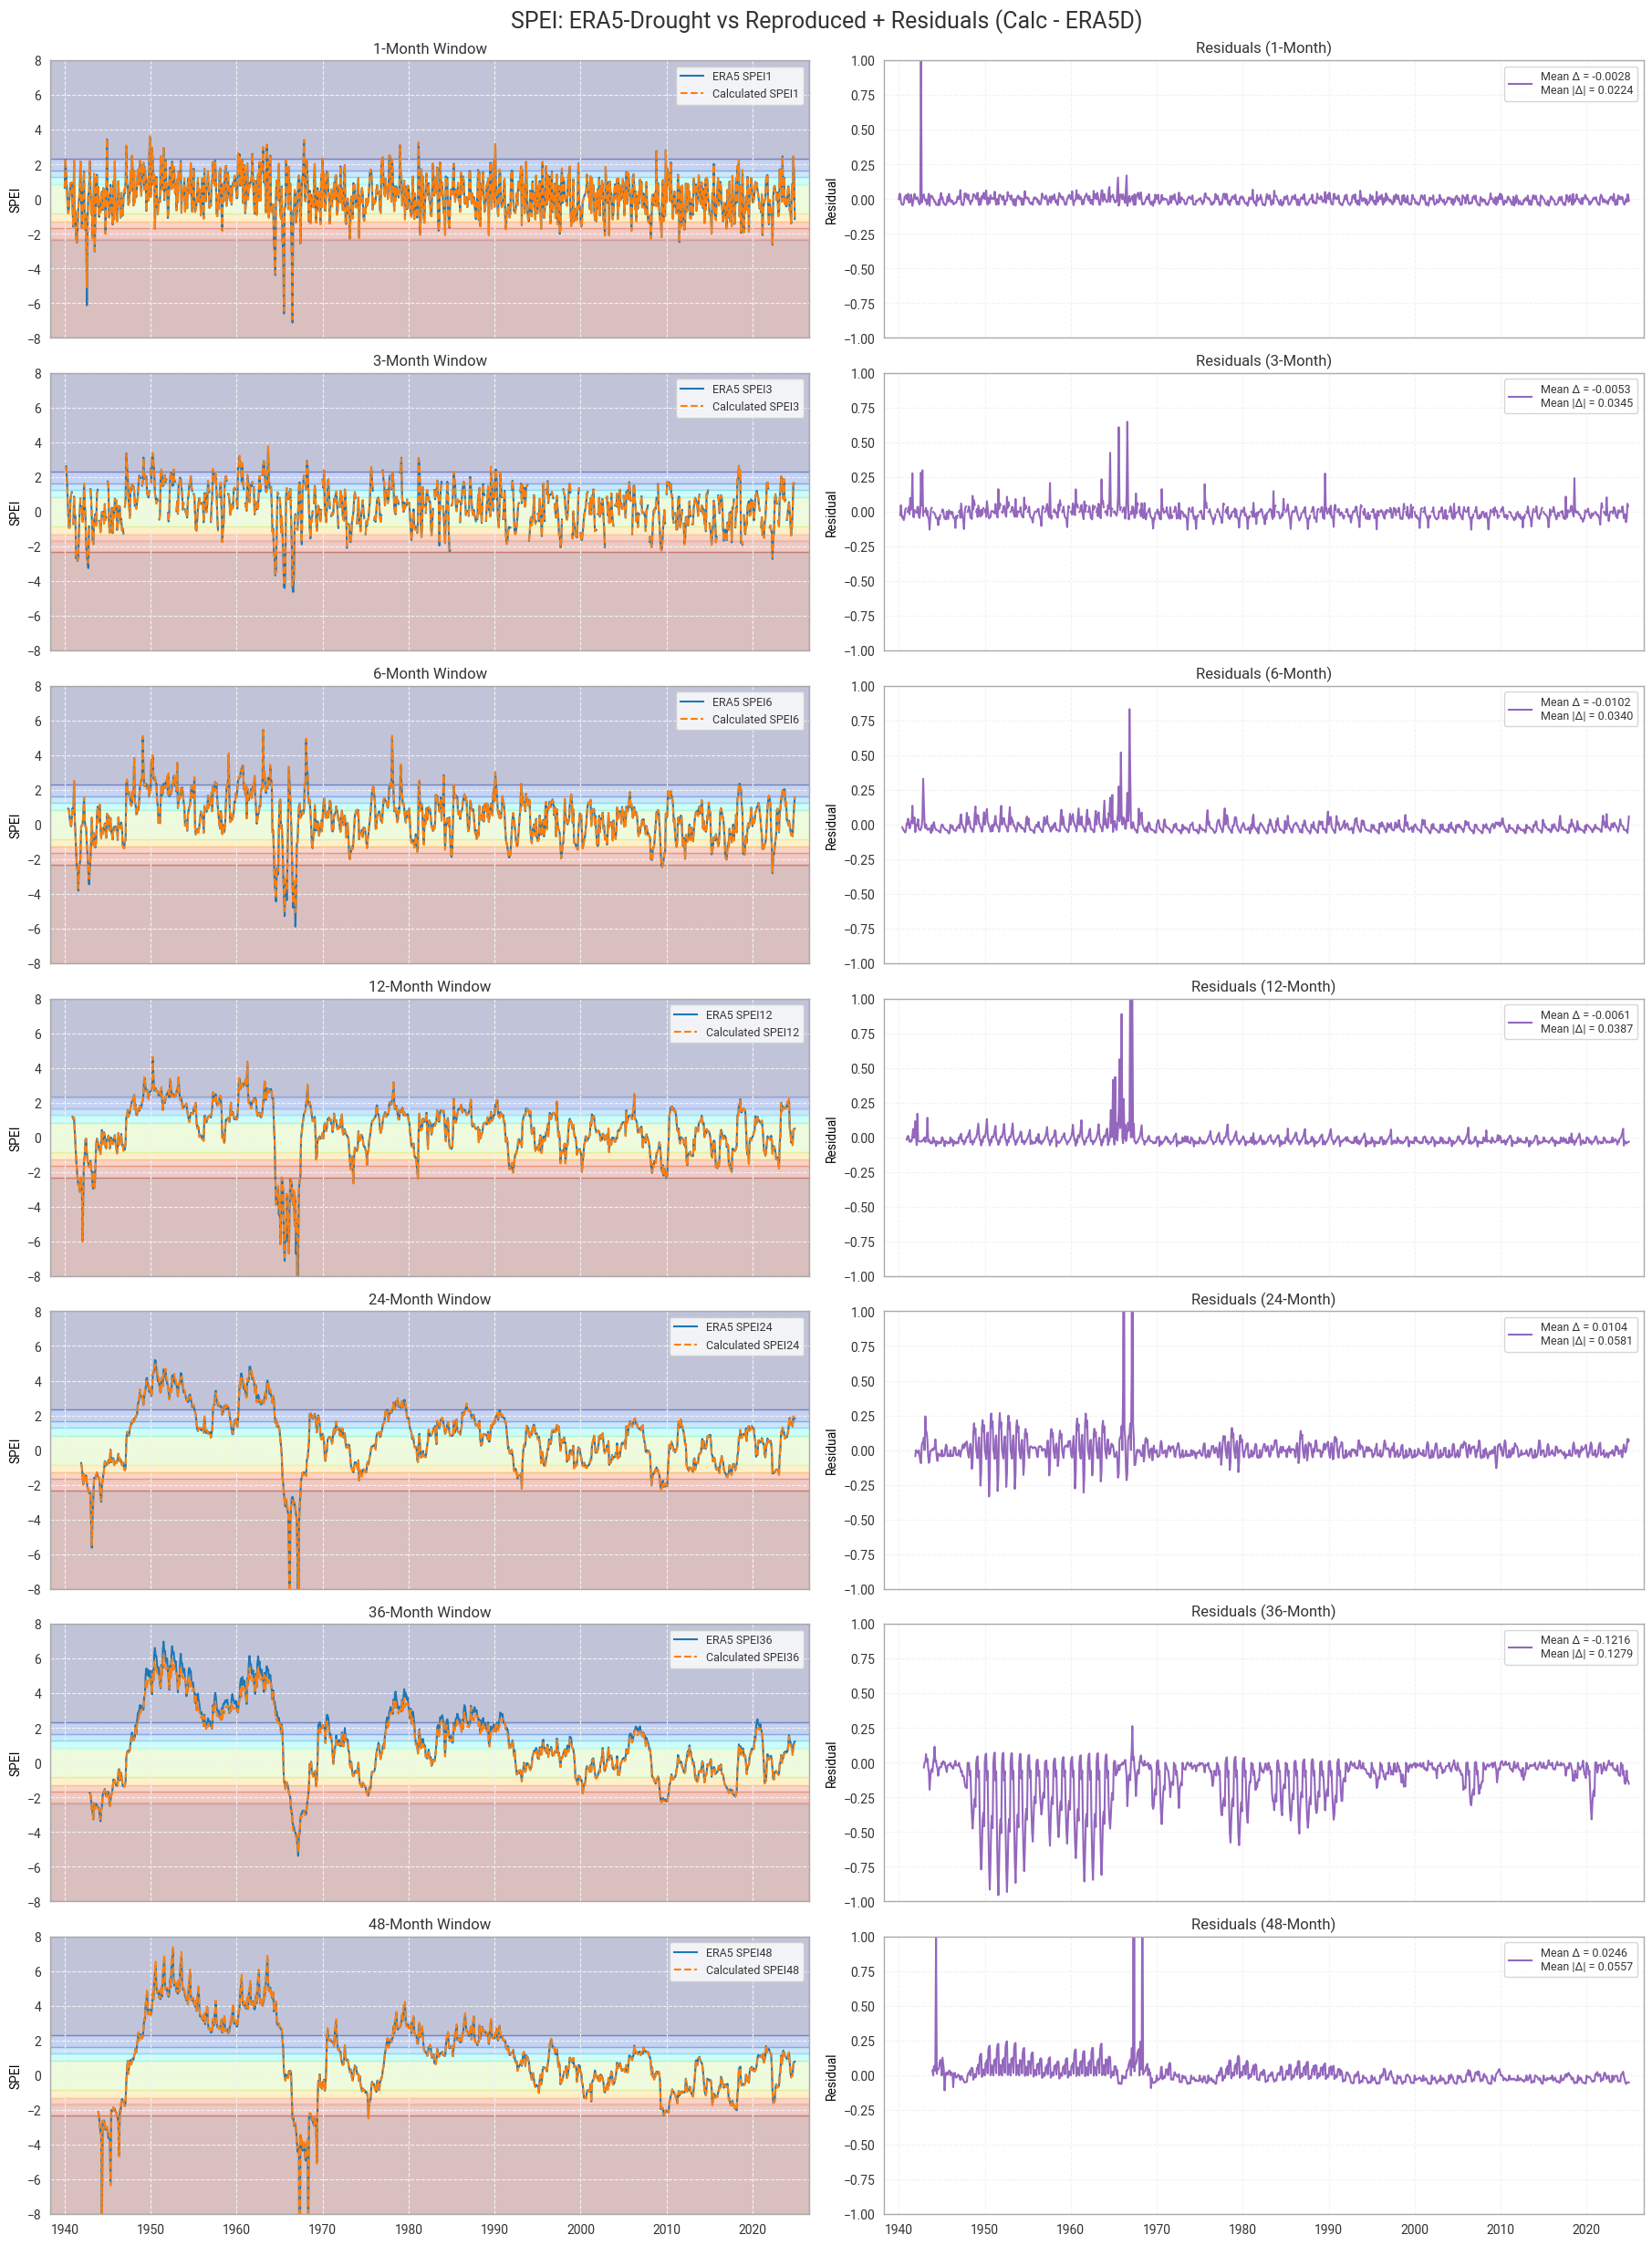

In [230]:
plot_index_comparison_side_by_side("SPEI", era5_masked, spei_ds_addis_masked, spei_categories) # takes a while

#### 3.7 Comparison of ERA5-Drought & Reproduced SPEI-index with quality flags (London & Denver)

In [ ]:
########################## TEDDINGTON (LONDON) DOWNLOAD ###########################################

tedd_req1 = {
    "variable": ["standardised_precipitation_evapotranspiration_index"],
    "accumulation_period": [str(p) for p in ACCUMULATION_PERIODS],
    "version": "1_0",
    "dataset_type": "consolidated_dataset",
    "month": [f"{m:02d}" for m in range(1, 13)],
    "area": area_dict["Teddington, United Kingdom"],
    "product_type": ["reanalysis"],
    "year": [str(y) for y in range(1940, 1981)],
}

tedd_req2 = {
    **tedd_req1,
    "year": [str(y) for y in range(1981, 2025)],
}

tedd_src = ekd.from_source("cds", ID_ERA5_DROUGHT, tedd_req1, tedd_req2)
tedd_ds = tedd_src.to_xarray(compat="equals")
tedd_point = tedd_ds.sel(coords_dict["Teddington, United Kingdom"])

########################## DENVER DOWNLOAD ###########################################

denver_req1 = {
    "variable": ["standardised_precipitation_evapotranspiration_index"],
    "accumulation_period": [str(p) for p in ACCUMULATION_PERIODS],
    "version": "1_0",
    "dataset_type": "consolidated_dataset",
    "month": [f"{m:02d}" for m in range(1, 13)],
    "area": area_dict["Denver, USA"],
    "product_type": ["reanalysis"],
    "year": [str(y) for y in range(1940, 1981)],
}

denver_req2 = {
    **denver_req1,
    "year": [str(y) for y in range(1981, 2025)],
}

spei_denver_src = ekd.from_source("cds", ID_ERA5_DROUGHT, denver_req1, denver_req2)
denver_ds = denver_src.to_xarray(compat="equals")
denv_point = denver_ds.sel(coords_dict["Denver, USA"])

(section-ens)=
### 5. Calculating the SPI/SPEI from ERA5 ensemble data.
Once again, calculating the SPI-index for all 10 ensemble members are the same as calculating the SPI index for one member, with the only modification being that there is an extra coordinate, "number" that identifies each ensemble member. 

Download monthly ensemble precipitation data, as before.

In [ ]:
request_era5_precipitation_edmo = {
    "param": "228.128",       # Variable: Total precipitation
    "stream": "edmo",         # Data stream: Monthly mean reanalysis
} | request_era5_template

In [ ]:
# Download data and convert to desired format
era5_monthly_mean_ens = ekd.from_source("cds", ID_ERA5, request_era5_precipitation_edmo)  # Download as field list
era5_monthly_mean_ens = era5_monthly_mean_ens.to_xarray(compat="equals")  # Convert to xarray dataset
era5_tp_monthly_mean_ens = rechunk(era5_monthly_mean_ens)  # Re-chunk for speed gain in fitting
era5_tp_monthly_mean_ens  # Display in notebook

And we also download the monthly-mean total potential evaporation data from the ERA5 reanalysis.

In [ ]:
request_era5_pev_edmo = {
    "param": "251.228",       # Variable: Potential evaporation (pev)
    "stream": "edmo",         # Data stream: Monthly mean reanalysis
} | request_era5_template

In [ ]:
# Download data and convert to desired format
era5_pev_monthly_mean_ens = ekd.from_source("cds", ID_ERA5, request_era5_pev_edmo)  # Download as field list
era5_pev_monthly_mean_ens = era5_pev_monthly_mean_ens.to_xarray(compat="equals")  # Convert to xarray dataset
era5_pev_monthly_mean_ens = rechunk(era5_pev_monthly_mean_ens)  # Re-chunk for speed gain in fitting

Precipitation is accumulated for all the accumulation periods in ERA5.

In [ ]:
example_site = {"latitude": 9.25, "longitude": 40.5,}

In [ ]:
# Select the grid point and time slice for Ethiopia
precipitation_example_site = era5_tp_monthly_mean_ens.sel(**example_site)

# Perform the accumulation for each accumulation period
precipitation_ens_example_site = accum_var(precipitation_example_site, "tp")

As is potential evaporaiton, for all the accumulation periods in ERA5.

In [ ]:
# Select the grid point and time slice for Ethiopia
pev_example_site = era5_pev_monthly_mean_ens.sel(**example_site)

# Perform the accumulation for each accumulation period
pev_ens_example_site = accum_var(pev_example_site, "pev")

The "water balance" is calculated, ensuring once again the -ve of the PET, as discussed earlier.  

In [ ]:
wb_ens_example_site = xr.Dataset(
    {
        f"wb_{var.replace('tp_', '')}": precipitation_ens_example_site[var]
                                       + pev_ens_example_site[var.replace("tp_", "pev_")]
        for var in precipitation_ens_example_site.data_vars # loop through every variable.
        if var.startswith("tp_") and var.replace("tp_", "pev_") in pev_ens_example_site.data_vars
    }
)

Gamma distribution is fitted for each calendar month (12) for each ensemble member (here, 10), with their parameters calculated.

In [ ]:
# Fit log logistic distributions
gamma_ens_params_fitted = fit_monthly_spi(precipitation_ens_example_site.sel(**reference_window))

Log-logistic distribution is fitted for each calendar month (12) for each ensemble member (here, 10), with their parameters calculated.

In [ ]:
log_logistic_ens_params_fitted = fit_monthly_spei(wb_ens_example_site.sel(**reference_window))

SPI is calculated for each accumulation period and each ensemble member from the fitted gamma distribution parameters.

In [ ]:
# Compute SPI series -- new function
cdf_ens_ds = compute_monthly_spi(precipitation_ens_example_site, gamma_ens_params_fitted)

SPEI is calculated for each accumulation period and each ensemble member from the fitted log-logistic distribution parameters.

In [ ]:
# Compute SPEI series -- new function
cdf_wb_ens_ds = compute_monthly_spei(wb_ens_example_site, log_logistic_ens_params_fitted)

Quality control is tested with the Shapiro-Wilks test on calculated ensemble SPI data.

In [ ]:
ens_spi_stat, ens_spi_pval, ens_spi_sig = xr_shapiro_test(spi_ens_ds, reference_window)

In [ ]:
quality_spi_ens_all = era5_drought_api_multiple(indicator = "spi", var = "quality", product_type = "ensemble_members")

Quality control using the Shapiro-Wilks test on calculated ensemble SPEI data.

In [ ]:
ens_spei_stat, ens_spei_pval, ens_spei_sig = xr_shapiro_test(spei_ens_ds, reference_window)

In [ ]:
quality_spei_ens_all = era5_drought_api_multiple(indicator = "spei", var = "quality", product_type = "ensemble_members")

Reading in ensemble SPI 

In [ ]:
era5_spi_ens = era5_drought_index_multiple("SPI", accum_period = [1,3])
era5_spi_ens = era5_spi_ens.sel(lat = 9.25, lon = 40.5)

Time-series comparison of SPI at one location 

In [ ]:
for m in range(0, 10):  #### patch this code so titles show which plot is which ensemble member. is obvious but for full thing?
    plot_index_comparison_side_by_side("SPI", era5_spi_ens.sel(number=m), spi_ens_ds.sel(number=m), accumulation_periods = [1]) 

In [ ]:
# TODO: Have a table for each accumulation window maybe.

Reading in ensemble SPEI

In [ ]:
era5_spei_ens = era5_drought_index_multiple("SPEI", accum_period = [3, 24, 48])
era5_spei_ens = era5_spei_ens.sel(lat = 9.25, lon = 40.5) ### data needs to be downloaded overnight, couldn't do it.

Time-series comparison of SPEI at one location 

In [ ]:
for m in range(0, 10):  #### patch this code so titles show which plot is which ensemble member. is obvious but for full thing?
    plot_index_comparison_side_by_side("SPEI", era5_spei_ens.sel(number=m), spei_ens_ds.sel(number=m), [3, 24, 48])

(section-conclusion)=
### 6. Conclusion

**SPI**- As shown in Section 2, the C3S ERA5 Drought SPI‑Indicator dataset and its manually reproduced counterpart are highly consistent. This agreement is evident across the full time series at a point location in Addis Ababa, Ethiopia, as well as regionally over the Horn of Africa and at additional sites in London, United Kingdom, and Denver, USA. The median difference and median absolute difference are both close to 0, and the vast majority of pixels exhibit a near‑zero difference (defined here as |Δ| ≤ ε with ε = 1×10⁻⁵ to avoid floating‑point artefacts) across all comparisons.

Furthermore, the "probability of zero precipitation" quality flag was also shown to be reproducible, globally, with no discrepancy. Since the Shapiro-Wilks quality flag is dependent on the dataset after statistical fitting, there was discrepancy at certain months, for Addis Ababa, and other locations...

We also examined discrepancies in drought‑severity categorisation between the C3S ERA5‑Drought dataset and the manually reproduced counterpart at individual locations, including Addis Ababa, London, and Denver. While the severity classifications were generally consistent between ERA5‑Drought and the reproduced dataset, there were instances at specific timestamps where the two SPI indicators diverged sufficiently to fall into different categories.

Overall, 

**SPEI**- Following on from Section 3, 

**SPI/SPEI Ensemble**- Lastly, as was shown in Section 4, 

## ℹ️ If you want to know more

This notebook is extremely long (by necessity) so it would be good to end on a recap with general conclusions.
For example, can you quantify the differences and tell me if those are a big deal in a general use case? As a user, I might not want to look at every panel in every figure, I just want to get a summary statistic and a general point.

### Key resources
The CDS catalogue entries for the data used were:
* Complete ERA5 global atmospheric reanalysis: [reanalysis-era5-complete](https://doi.org/10.24381/cds.143582cf)
* Monthly drought indices from 1940 to present derived from ERA5 reanalysis: [derived-drought-historical-monthly](https://doi.org/10.24381/9bea5e16)

Code libraries used:
* [earthkit](https://github.com/ecmwf/earthkit)
  * [earthkit-data](https://github.com/ecmwf/earthkit-data)
  * [earthkit-plots](https://github.com/ecmwf/earthkit-plots)
    
### References

[[1]](https://doi.org/10.59327/IPCC/AR6-9789291691647) IPCC, 2023: Sections. In: Climate Change 2023: Synthesis Report. Contribution of Working Groups I, II and III to the Sixth Assessment Report of the Intergovernmental Panel on Climate Change [Core Writing Team, H. Lee and J. Romero (eds.)]. IPCC, Geneva, Switzerland, pp. 35-115, doi: 10.59327/IPCC/AR6-9789291691647

[[2]](https://mcusercontent.com/8ed7ad7972fae058e8f4fb7e8/files/6d02e6e7-8639-a44d-5a8c-2313124ef699/Costs_of_climate_analysis_011225.pdf) Estimated financial losses faced by UK farmers due dry weather impacts on key arable crops - Energy & Climate Intelligence Unit

[[3]](https://www.unicef.org/media/165191/file/LACR-Flash-Update-11-November-2024.pdf) Climate-related crisis in the Amazon region Flash Update No. 2, Brazil, Peru, Bolivia, Columbia - UNICEF, 2024

[[5]](https://doi.org/10.1080/01431160500296032) Vicente‐Serrano, S.M., Cuadrat‐Prats, J.M. and Romo, A., 2006. Early prediction of crop production using drought indices at different time‐scales and remote sensing data: application in the Ebro Valley (north‐east Spain). International Journal of Remote Sensing, 27(3), pp.511-518.

[[6]](https://doi.org/10.1016/j.agrformet.2017.01.021) Russo, A., Gouveia, C.M., Páscoa, P., DaCamara, C.C., Sousa, P.M. and Trigo, R.M., 2017. Assessing the role of drought events on wildfires in the Iberian Peninsula. Agricultural and Forest Meteorology, 237, pp.50-59.

[[7]](https://climate.colostate.edu/pdfs/relationshipofdroughtfrequency.pdf) McKee, T.B., Doesken, N.J. and Kleist, J., 1993, January. The relationship of drought frequency and duration to time scales. In Proceedings of the 8th Conference on Applied Climatology (Vol. 17, No. 22, pp. 179-183).

[[8]](https://doi.org/10.1175/2009JCLI2909.1) Vicente-Serrano, S.M., Beguería, S. and López-Moreno, J.I., 2010. A multiscalar drought index sensitive to global warming: the standardized precipitation evapotranspiration index. Journal of climate, 23(7), pp.1696-1718.

[[9]](https://doi.org/10.1038/s41597-025-04896-y) Keune, J., Di Giuseppe, F., Barnard, C., Damasio da Costa, E. and Wetterhall, F., 2025. ERA5–Drought: Global drought indices based on ECMWF reanalysis. Scientific Data, 12(1), p.616.